# compare two runs in Run 6

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sys
import copy
from matplotlib import pyplot as plt
from matplotlib import lines
from mpl_toolkits import axes_grid1
from astropy.stats import sigma_clip
from scipy.stats import skew
from tabulate import tabulate

import lsst.daf.butler as daf_butler
import lsst.afw.math as afw_math
from lsst.obs.lsst import LsstCam, LsstTS8
import lsst.eo.pipe as eo_pipe
from lsst.eo.pipe import (readNoiseTask, darkCurrentTask, defectsTask,
                          eperTask, divisaderoTearingTask, ptcPlotsTask,
                          linearityPlotsTask, bfAnalysisTask)

from myutils import *

# Code

In [2]:
def get_run_data(acq_run,weekly='w_2023_24',operator='lsstccs',repo='/repo/ir2',verbose=0):
    
    # We use the collection naming scheme to find all of the chained collections for an eo_pipe analysis of 
    # the specified run.  For our dataset queries, we'll use these collections.
    butler = daf_butler.Butler(repo)
    collections = butler.registry.queryCollections(f"u/{operator}/eo_*_{acq_run}_{weekly}",
                                               collectionTypes=daf_butler.CollectionType.CHAINED)
    if verbose>0:
        for item in collections:
            print(item)
            
    # Several eo_pipe pipelines produce per-amp measurements for all of the CCDs in the current Camera object.
    # For LSSTCam, this would include all 205 CCDs in the focal plane; for TS8, this would be the 9 CCDs in 
    # the raft installed at that test stand (currently RTM-004).
    #
    # The `eo_pipe.get_amp_data` function will retrieve these per-amp measurements and return them as a 
    # three-level dictionary, keyed by measurement quantity, CCD (labeled by R**_S for LSSTCam), and 
    # amplifier data (labeled by channel name, e.g., 'C01').
    #
    # The '[ps]cti' quantities are measured from combined flats, so will have different values depending on the
    # filter used, since combined flats a created separately for each filter combination.
    amp_data = eo_pipe.get_amp_data(repo, collections)
    if verbose>0:
        for quantity in amp_data.keys():
            print(quantity)
            
    df_data = eopipe_DictToDfz(amp_data)
    if verbose>0:
        print(df_data.columns)
        
    return amp_data,df_data

In [3]:
acq_run1 = '13391'
amp_data_run1,df_data_run1 = get_run_data(acq_run1)

In [7]:
acq_run2 = '13410'
amp_data_run2,df_data_run2 = get_run_data(acq_run2,weekly='w_2023_25')

In [8]:
print(df_data_run1.columns)

Index(['READ_NOISE', 'BRIGHT_COLUMNS', 'BRIGHT_PIXELS', 'DARK_COLUMNS',
       'DARK_PIXELS', 'DARK_CURRENT_95', 'DARK_CURRENT_MEDIAN',
       'DIVISADERO_TEARING', 'PTC_A00', 'PTC_GAIN', 'PTC_TURNOFF', 'PTC_NOISE',
       'ROW_MEAN_VAR_SLOPE', 'MAX_FRAC_DEV', 'MAX_OBSERVED_SIGNAL',
       'LINEARITY_TURNOFF', 'BF_XCORR', 'BF_YCORR', 'BF_MEAN', 'BF_SLOPE_X',
       'BF_SLOPE_X_ERR', 'BF_SLOPE_Y', 'BF_SLOPE_Y_ERR', 'SCTI_LOW',
       'PCTI_LOW', 'SCTI_HIGH', 'PCTI_HIGH', 'BAY', 'SLOT', 'AMP', 'BAYTYPE',
       'BAY_SLOT', 'SEGMENT'],
      dtype='object')


In [19]:
# merge the DataFrames
df_merge1 = df_data_run1.merge(df_data_run2,how='outer',on=['BAY_SLOT','SEGMENT','BAY','SLOT','AMP','BAYTYPE'],suffixes=('_RUN1','_RUN2'))

In [20]:
# variables with XX and XX_RUN5 are in both DataFrames 
print(df_merge1.columns)

Index(['READ_NOISE_RUN1', 'BRIGHT_COLUMNS_RUN1', 'BRIGHT_PIXELS_RUN1',
       'DARK_COLUMNS_RUN1', 'DARK_PIXELS_RUN1', 'DARK_CURRENT_95_RUN1',
       'DARK_CURRENT_MEDIAN_RUN1', 'DIVISADERO_TEARING_RUN1', 'PTC_A00_RUN1',
       'PTC_GAIN_RUN1', 'PTC_TURNOFF_RUN1', 'PTC_NOISE_RUN1',
       'ROW_MEAN_VAR_SLOPE_RUN1', 'MAX_FRAC_DEV_RUN1',
       'MAX_OBSERVED_SIGNAL_RUN1', 'LINEARITY_TURNOFF_RUN1', 'BF_XCORR_RUN1',
       'BF_YCORR_RUN1', 'BF_MEAN_RUN1', 'BF_SLOPE_X_RUN1',
       'BF_SLOPE_X_ERR_RUN1', 'BF_SLOPE_Y_RUN1', 'BF_SLOPE_Y_ERR_RUN1',
       'SCTI_LOW_RUN1', 'PCTI_LOW_RUN1', 'SCTI_HIGH_RUN1', 'PCTI_HIGH_RUN1',
       'BAY', 'SLOT', 'AMP', 'BAYTYPE', 'BAY_SLOT', 'SEGMENT',
       'READ_NOISE_RUN2', 'BRIGHT_COLUMNS_RUN2', 'BRIGHT_PIXELS_RUN2',
       'DARK_COLUMNS_RUN2', 'DARK_PIXELS_RUN2', 'DARK_CURRENT_95_RUN2',
       'DARK_CURRENT_MEDIAN_RUN2', 'DIVISADERO_TEARING_RUN2', 'PTC_A00_RUN2',
       'PTC_GAIN_RUN2', 'PTC_TURNOFF_RUN2', 'PTC_NOISE_RUN2',
       'ROW_MEAN_VAR_SLOPE_RUN

In [21]:
## Get list of known problem channels
def mkdf_badchannels():
    
    baddict = {}
    baddict['R30_S00_C10'] = 'Dead Channel'
    baddict['R03_S11_C00'] = 'Dead Channel'
    baddict['R04_SG0_C11'] = 'Dead Channel'
    baddict['R40_SG1_C10'] = 'High Read Noise'
    baddict['R44_SG0_C02'] = 'High Read Noise'
    baddict['R41_S21_C02'] = 'High Read Noise'
    baddict['R43_S20_C14'] = 'High Read Noise'
    baddict['R01_S02_C07'] = 'High Read Noise'
    baddict['R01_S10_C11'] = 'Bright Defect'
    baddict['R01_S00_C14'] = 'Bright Defect'
    baddict['R01_S01_C00'] = 'Formerly Dead, Alive in Run5'
    baddict['R10_S00_C00'] = 'Formerly Dead, Alive in Run5'


    comments = []
    allbayslot = []
    allsegment = []  # Cxx 
    for i, det in enumerate(camera):
        bayslot = det.getName()
        segments = det.getAmplifiers()
        for j,seg in enumerate(segments):
            fullname = bayslot+"_"+seg.getName()
        
            allbayslot.append(bayslot)
            allsegment.append(seg.getName())
            if fullname in baddict:
                comments.append(baddict[fullname])
            else:
                comments.append('Ok')
    
    # output dictionary
    cdf = {}
            
    # add to DF with ccd info
    cdf['BAY_SLOT'] = allbayslot
    cdf['SEGMENT'] = allsegment
    cdf['COMMENT'] = comments
                    
    # fill 
    df = pd.DataFrame(cdf)
    df.columns = df.columns.str.upper()
    return df

In [22]:
df_comment = mkdf_badchannels()

In [23]:
df_merge = df_merge1.merge(df_comment,how='outer',on=['BAY_SLOT','SEGMENT'],suffixes=('','_COMMENT'))

In [24]:
print(df_merge.columns)

Index(['READ_NOISE_RUN1', 'BRIGHT_COLUMNS_RUN1', 'BRIGHT_PIXELS_RUN1',
       'DARK_COLUMNS_RUN1', 'DARK_PIXELS_RUN1', 'DARK_CURRENT_95_RUN1',
       'DARK_CURRENT_MEDIAN_RUN1', 'DIVISADERO_TEARING_RUN1', 'PTC_A00_RUN1',
       'PTC_GAIN_RUN1', 'PTC_TURNOFF_RUN1', 'PTC_NOISE_RUN1',
       'ROW_MEAN_VAR_SLOPE_RUN1', 'MAX_FRAC_DEV_RUN1',
       'MAX_OBSERVED_SIGNAL_RUN1', 'LINEARITY_TURNOFF_RUN1', 'BF_XCORR_RUN1',
       'BF_YCORR_RUN1', 'BF_MEAN_RUN1', 'BF_SLOPE_X_RUN1',
       'BF_SLOPE_X_ERR_RUN1', 'BF_SLOPE_Y_RUN1', 'BF_SLOPE_Y_ERR_RUN1',
       'SCTI_LOW_RUN1', 'PCTI_LOW_RUN1', 'SCTI_HIGH_RUN1', 'PCTI_HIGH_RUN1',
       'BAY', 'SLOT', 'AMP', 'BAYTYPE', 'BAY_SLOT', 'SEGMENT',
       'READ_NOISE_RUN2', 'BRIGHT_COLUMNS_RUN2', 'BRIGHT_PIXELS_RUN2',
       'DARK_COLUMNS_RUN2', 'DARK_PIXELS_RUN2', 'DARK_CURRENT_95_RUN2',
       'DARK_CURRENT_MEDIAN_RUN2', 'DIVISADERO_TEARING_RUN2', 'PTC_A00_RUN2',
       'PTC_GAIN_RUN2', 'PTC_TURNOFF_RUN2', 'PTC_NOISE_RUN2',
       'ROW_MEAN_VAR_SLOPE_RUN

# Comparison histograms

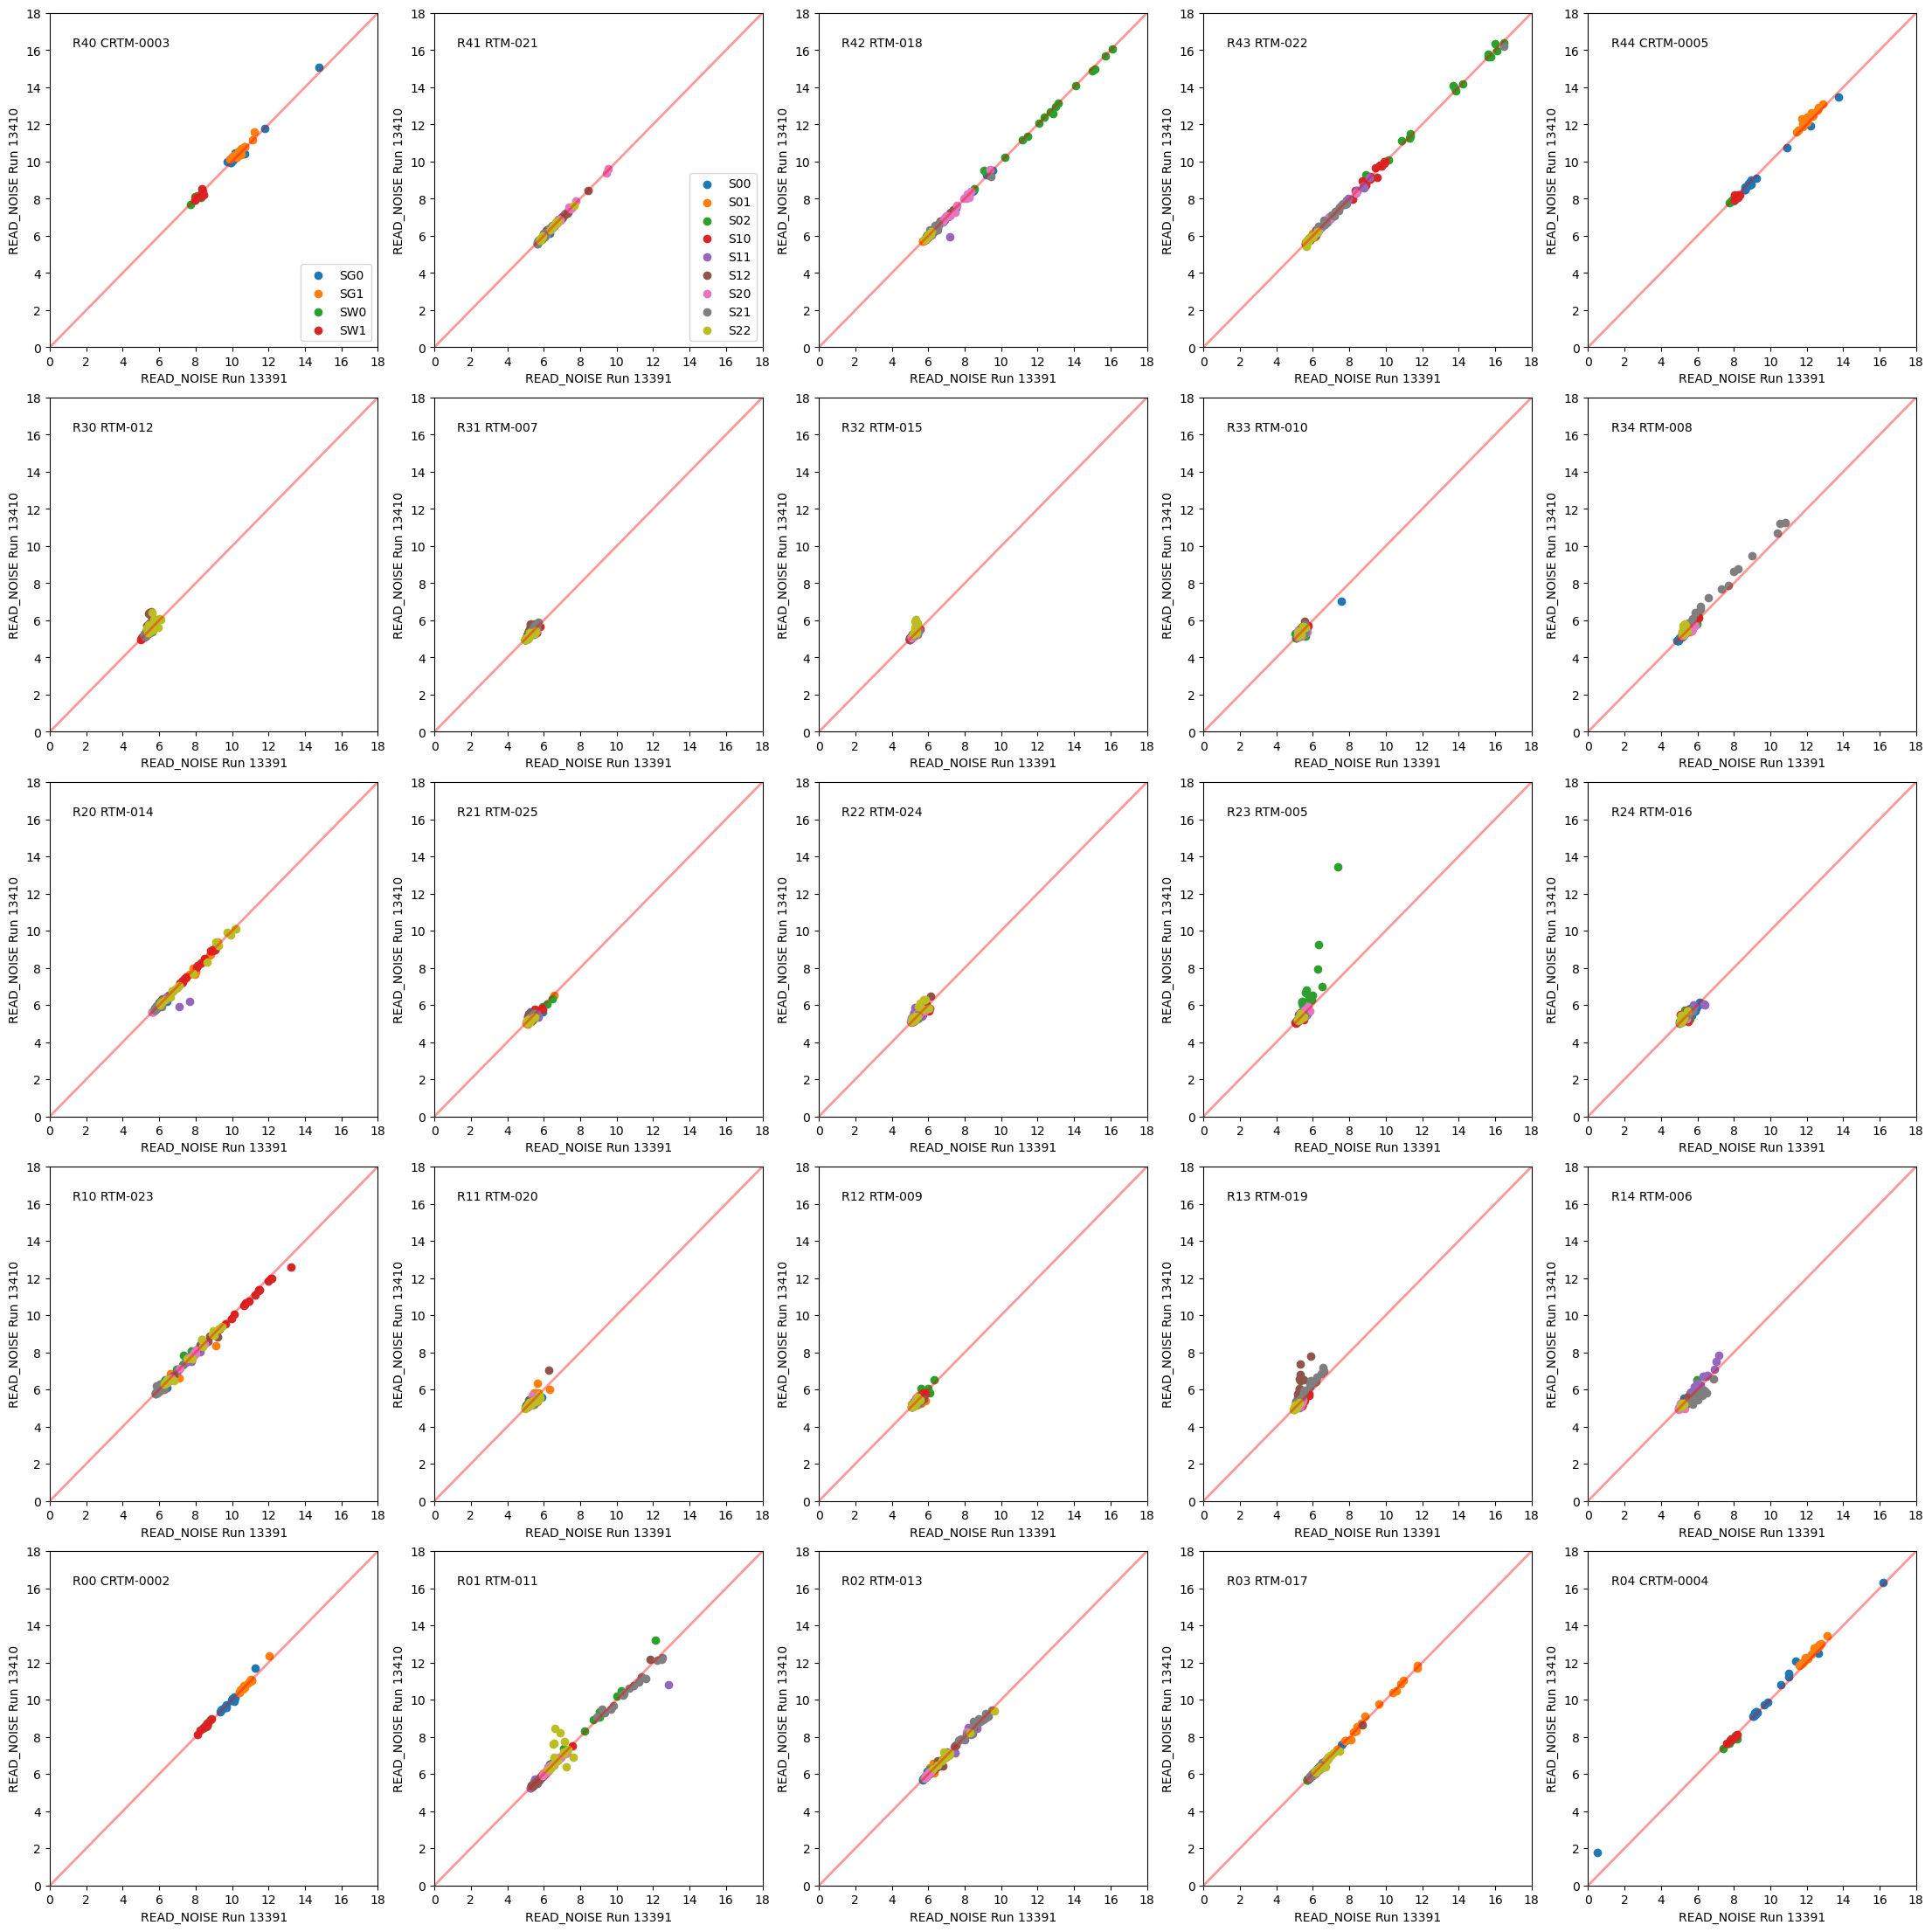

In [25]:
compare_tworuns(df_data_run1,df_data_run2,acq_run1,acq_run2,quantity='READ_NOISE',minxy=0.0,maxxy=18.0,save='read_noise_%s_vs_%s'%(acq_run1,acq_run2))

## High Noise channels

In [26]:
highnoise = (df_merge.READ_NOISE_RUN1>18.0) | (df_merge.READ_NOISE_RUN2>18.0)
print(tabulate(df_merge[highnoise][['BAY_SLOT','SEGMENT','READ_NOISE_RUN1','PTC_GAIN_RUN1','READ_NOISE_RUN2','PTC_GAIN_RUN2','COMMENT']],headers='keys',tablefmt='psql'))

+------+------------+-----------+-------------------+-----------------+-------------------+-----------------+------------------------------+
|      | BAY_SLOT   | SEGMENT   |   READ_NOISE_RUN1 |   PTC_GAIN_RUN1 |   READ_NOISE_RUN2 |   PTC_GAIN_RUN2 | COMMENT                      |
|------+------------+-----------+-------------------+-----------------+-------------------+-----------------+------------------------------|
|   79 | R01_S01    | C00       |           43.3449 |       14.5068   |           6.08847 |         1.6551  | Formerly Dead, Alive in Run5 |
|  415 | R03_S11    | C00       |           33.5159 |       11.7085   |          45.147   |        15.7955  | Dead Channel                 |
| 2704 | R40_SG1    | C10       |          210.592  |        2.4366   |         nan       |       nan       | High Read Noise              |
| 2861 | R41_S21    | C02       |          nan      |      nan        |          66.441   |         1.6789  | High Read Noise              |
| 3124 | R43_

In [27]:
lownoise = (df_merge.READ_NOISE_RUN1<4.5) | (df_merge.READ_NOISE_RUN2<4.5)
print(tabulate(df_merge[lownoise][['BAY_SLOT','SEGMENT','READ_NOISE_RUN1','PTC_GAIN_RUN1','READ_NOISE_RUN2','PTC_GAIN_RUN2','COMMENT']],headers='keys',tablefmt='psql'))

+-----+------------+-----------+-------------------+-----------------+-------------------+-----------------+--------------+
|     | BAY_SLOT   | SEGMENT   |   READ_NOISE_RUN1 |   PTC_GAIN_RUN1 |   READ_NOISE_RUN2 |   PTC_GAIN_RUN2 | COMMENT      |
|-----+------------+-----------+-------------------+-----------------+-------------------+-----------------+--------------|
| 481 | R04_SG0    | C11       |          0.499504 |       0.0407857 |             1.793 |        0.145928 | Dead Channel |
+-----+------------+-----------+-------------------+-----------------+-------------------+-----------------+--------------+


# PTC Gain

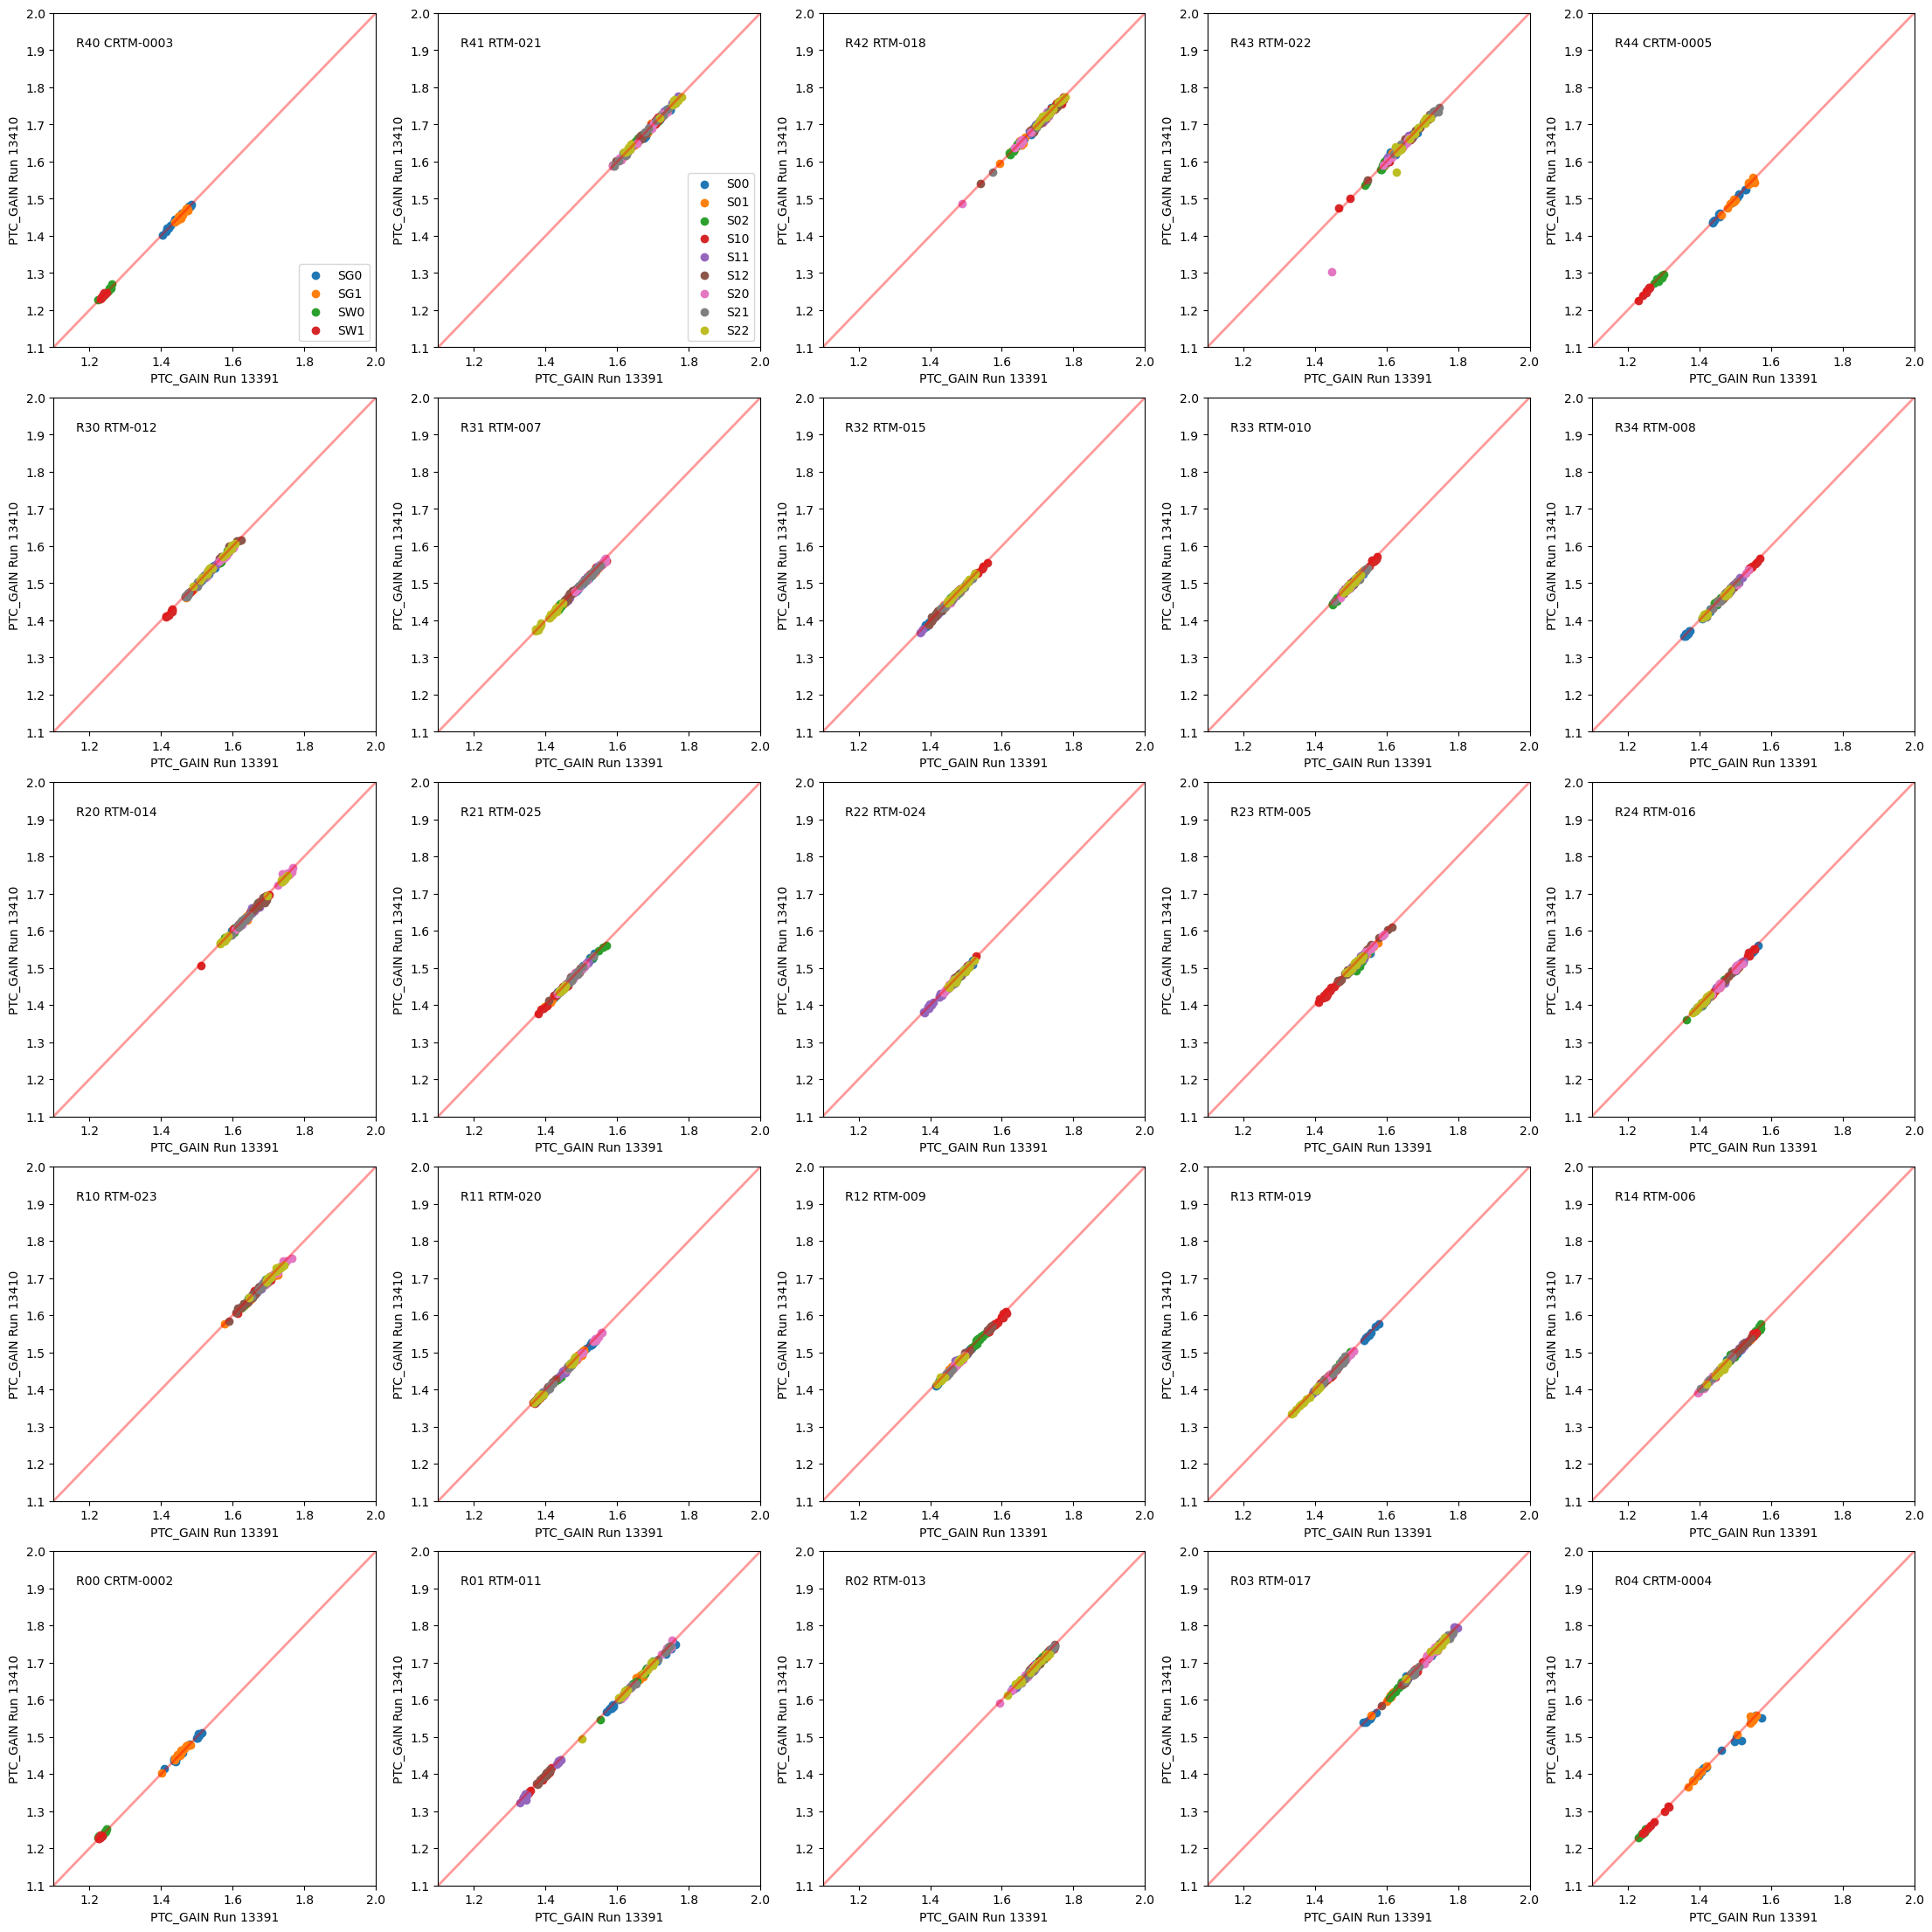

In [28]:
compare_tworuns(df_data_run1,df_data_run2,acq_run1,acq_run2,quantity='PTC_GAIN',minxy=1.1,maxxy=2.0,save='ptc_gain_%s_vs_%s'%(acq_run1,acq_run2))

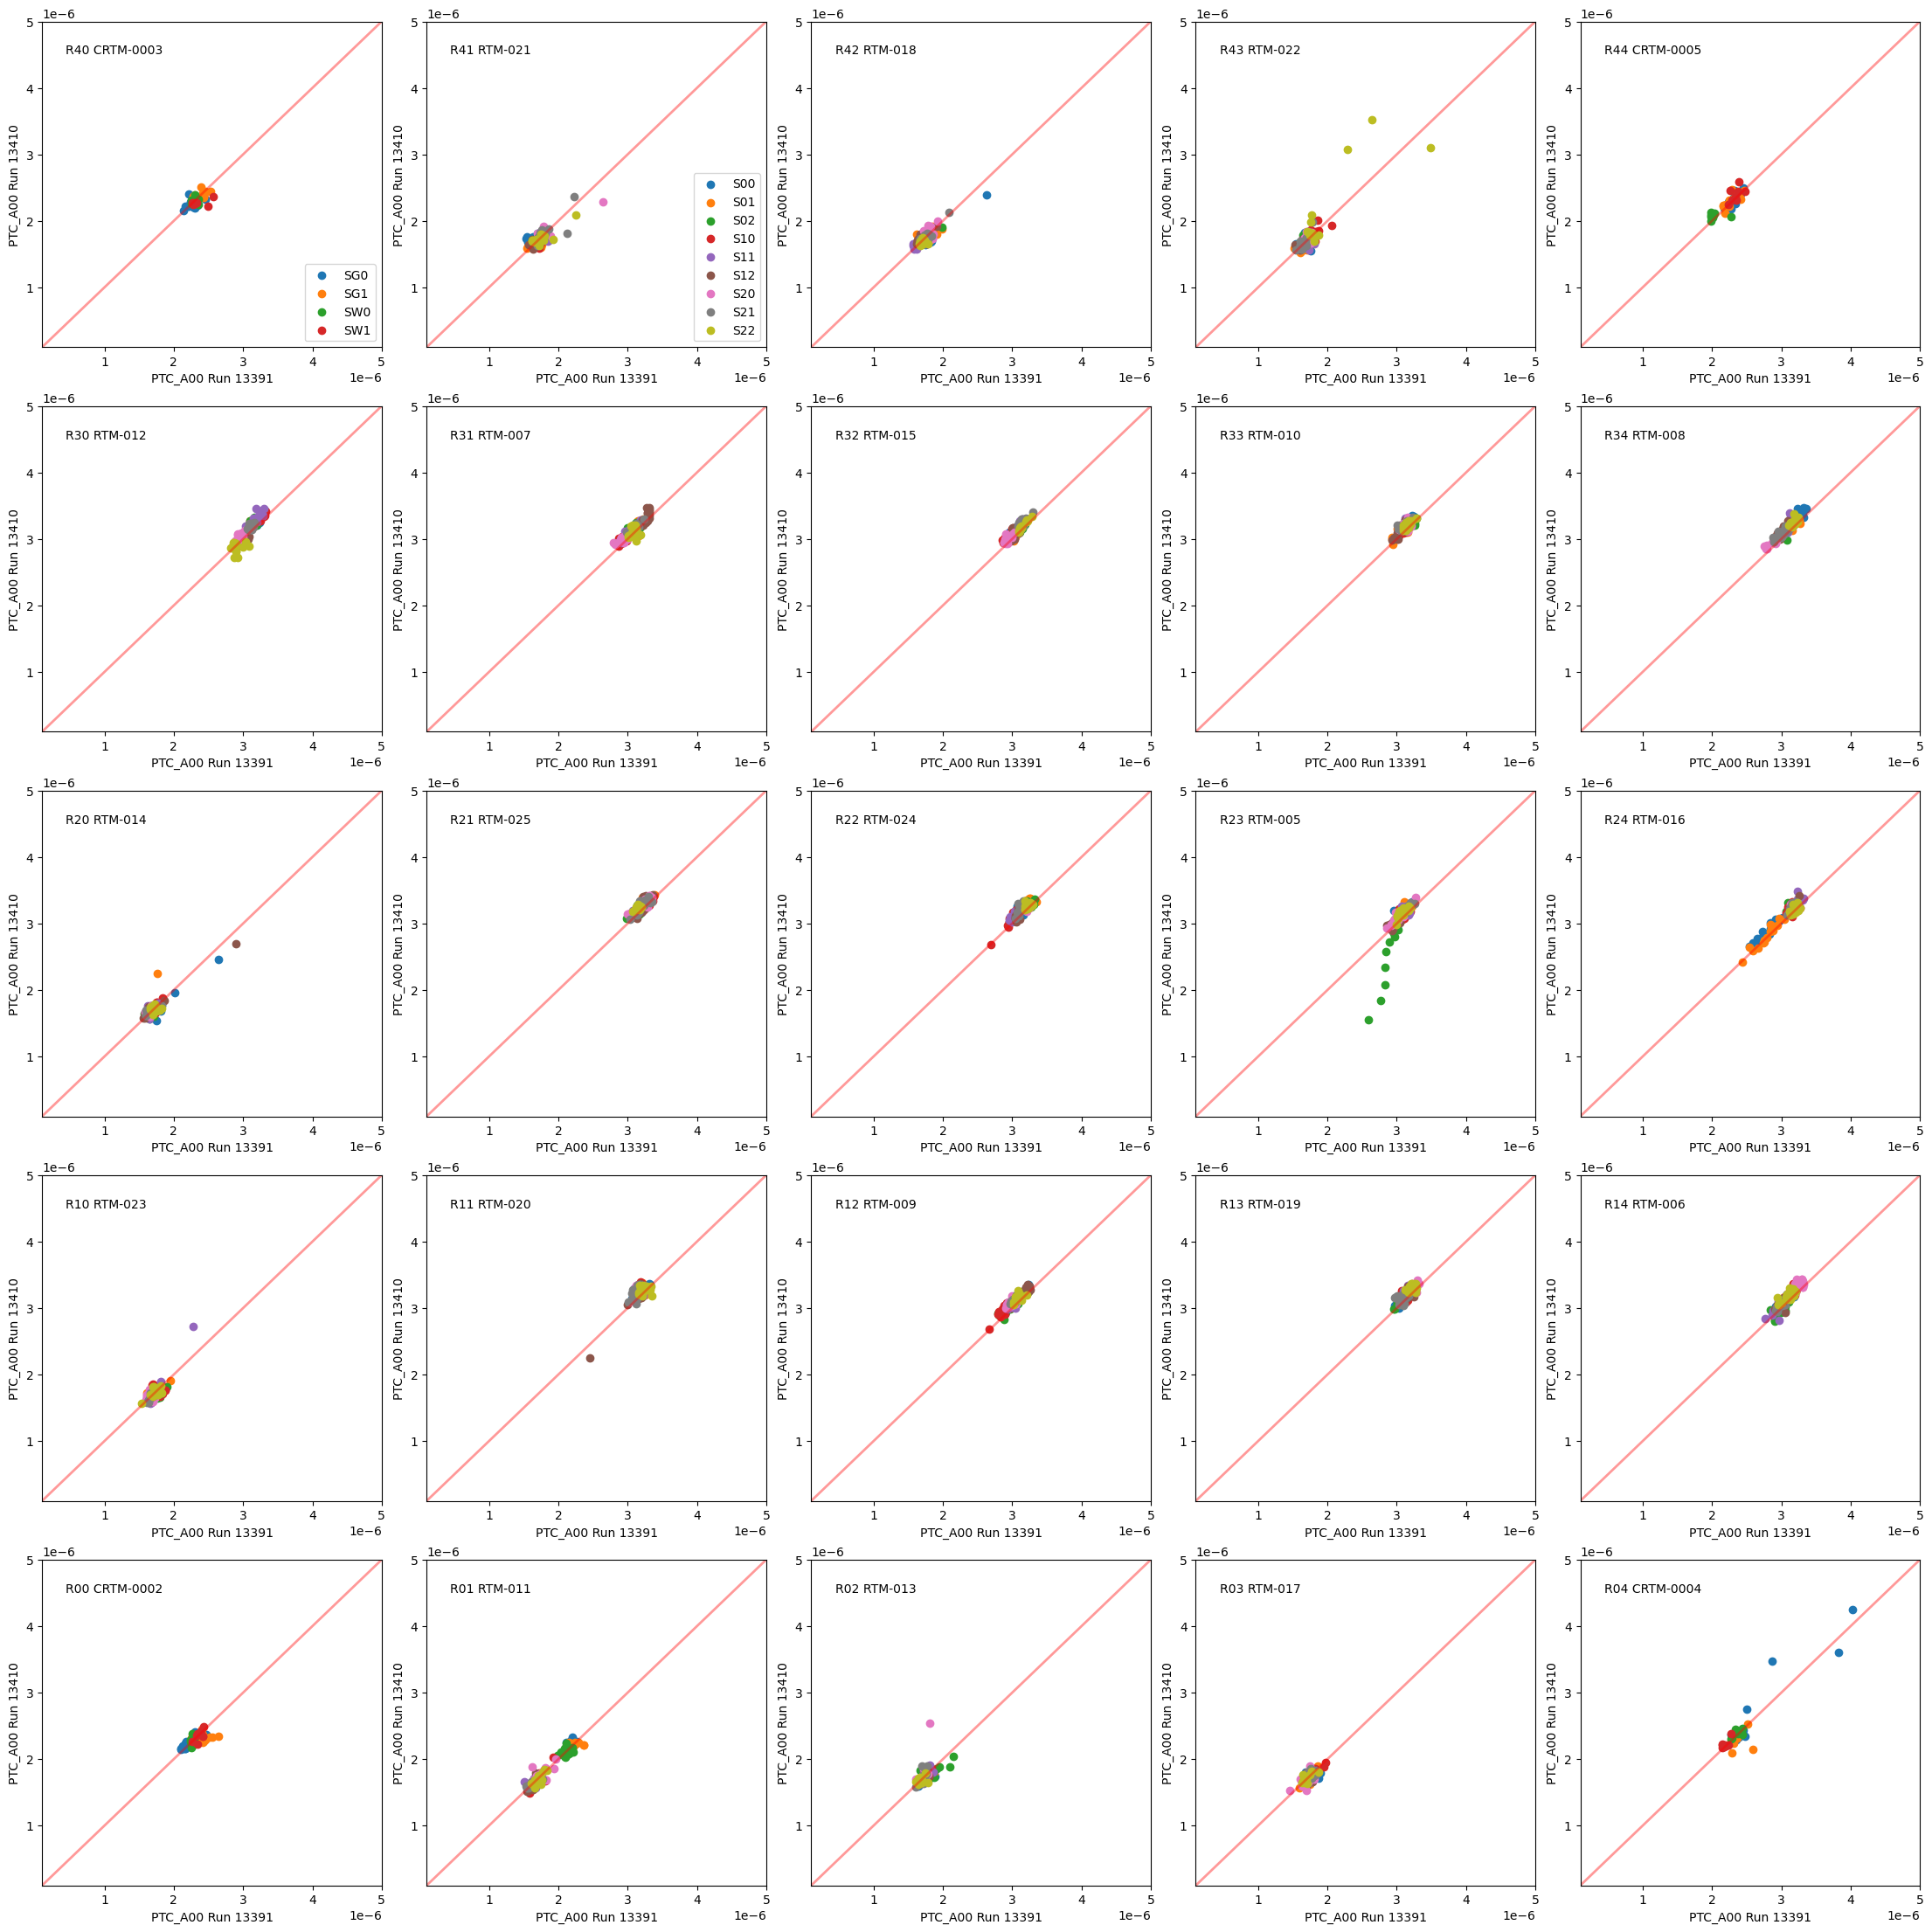

In [29]:
compare_tworuns(df_data_run1,df_data_run2,acq_run1,acq_run2,quantity='PTC_A00',minxy=1.e-7,maxxy=0.5e-5,save='ptc_a00_%s_vs_%s'%(acq_run1,acq_run2))

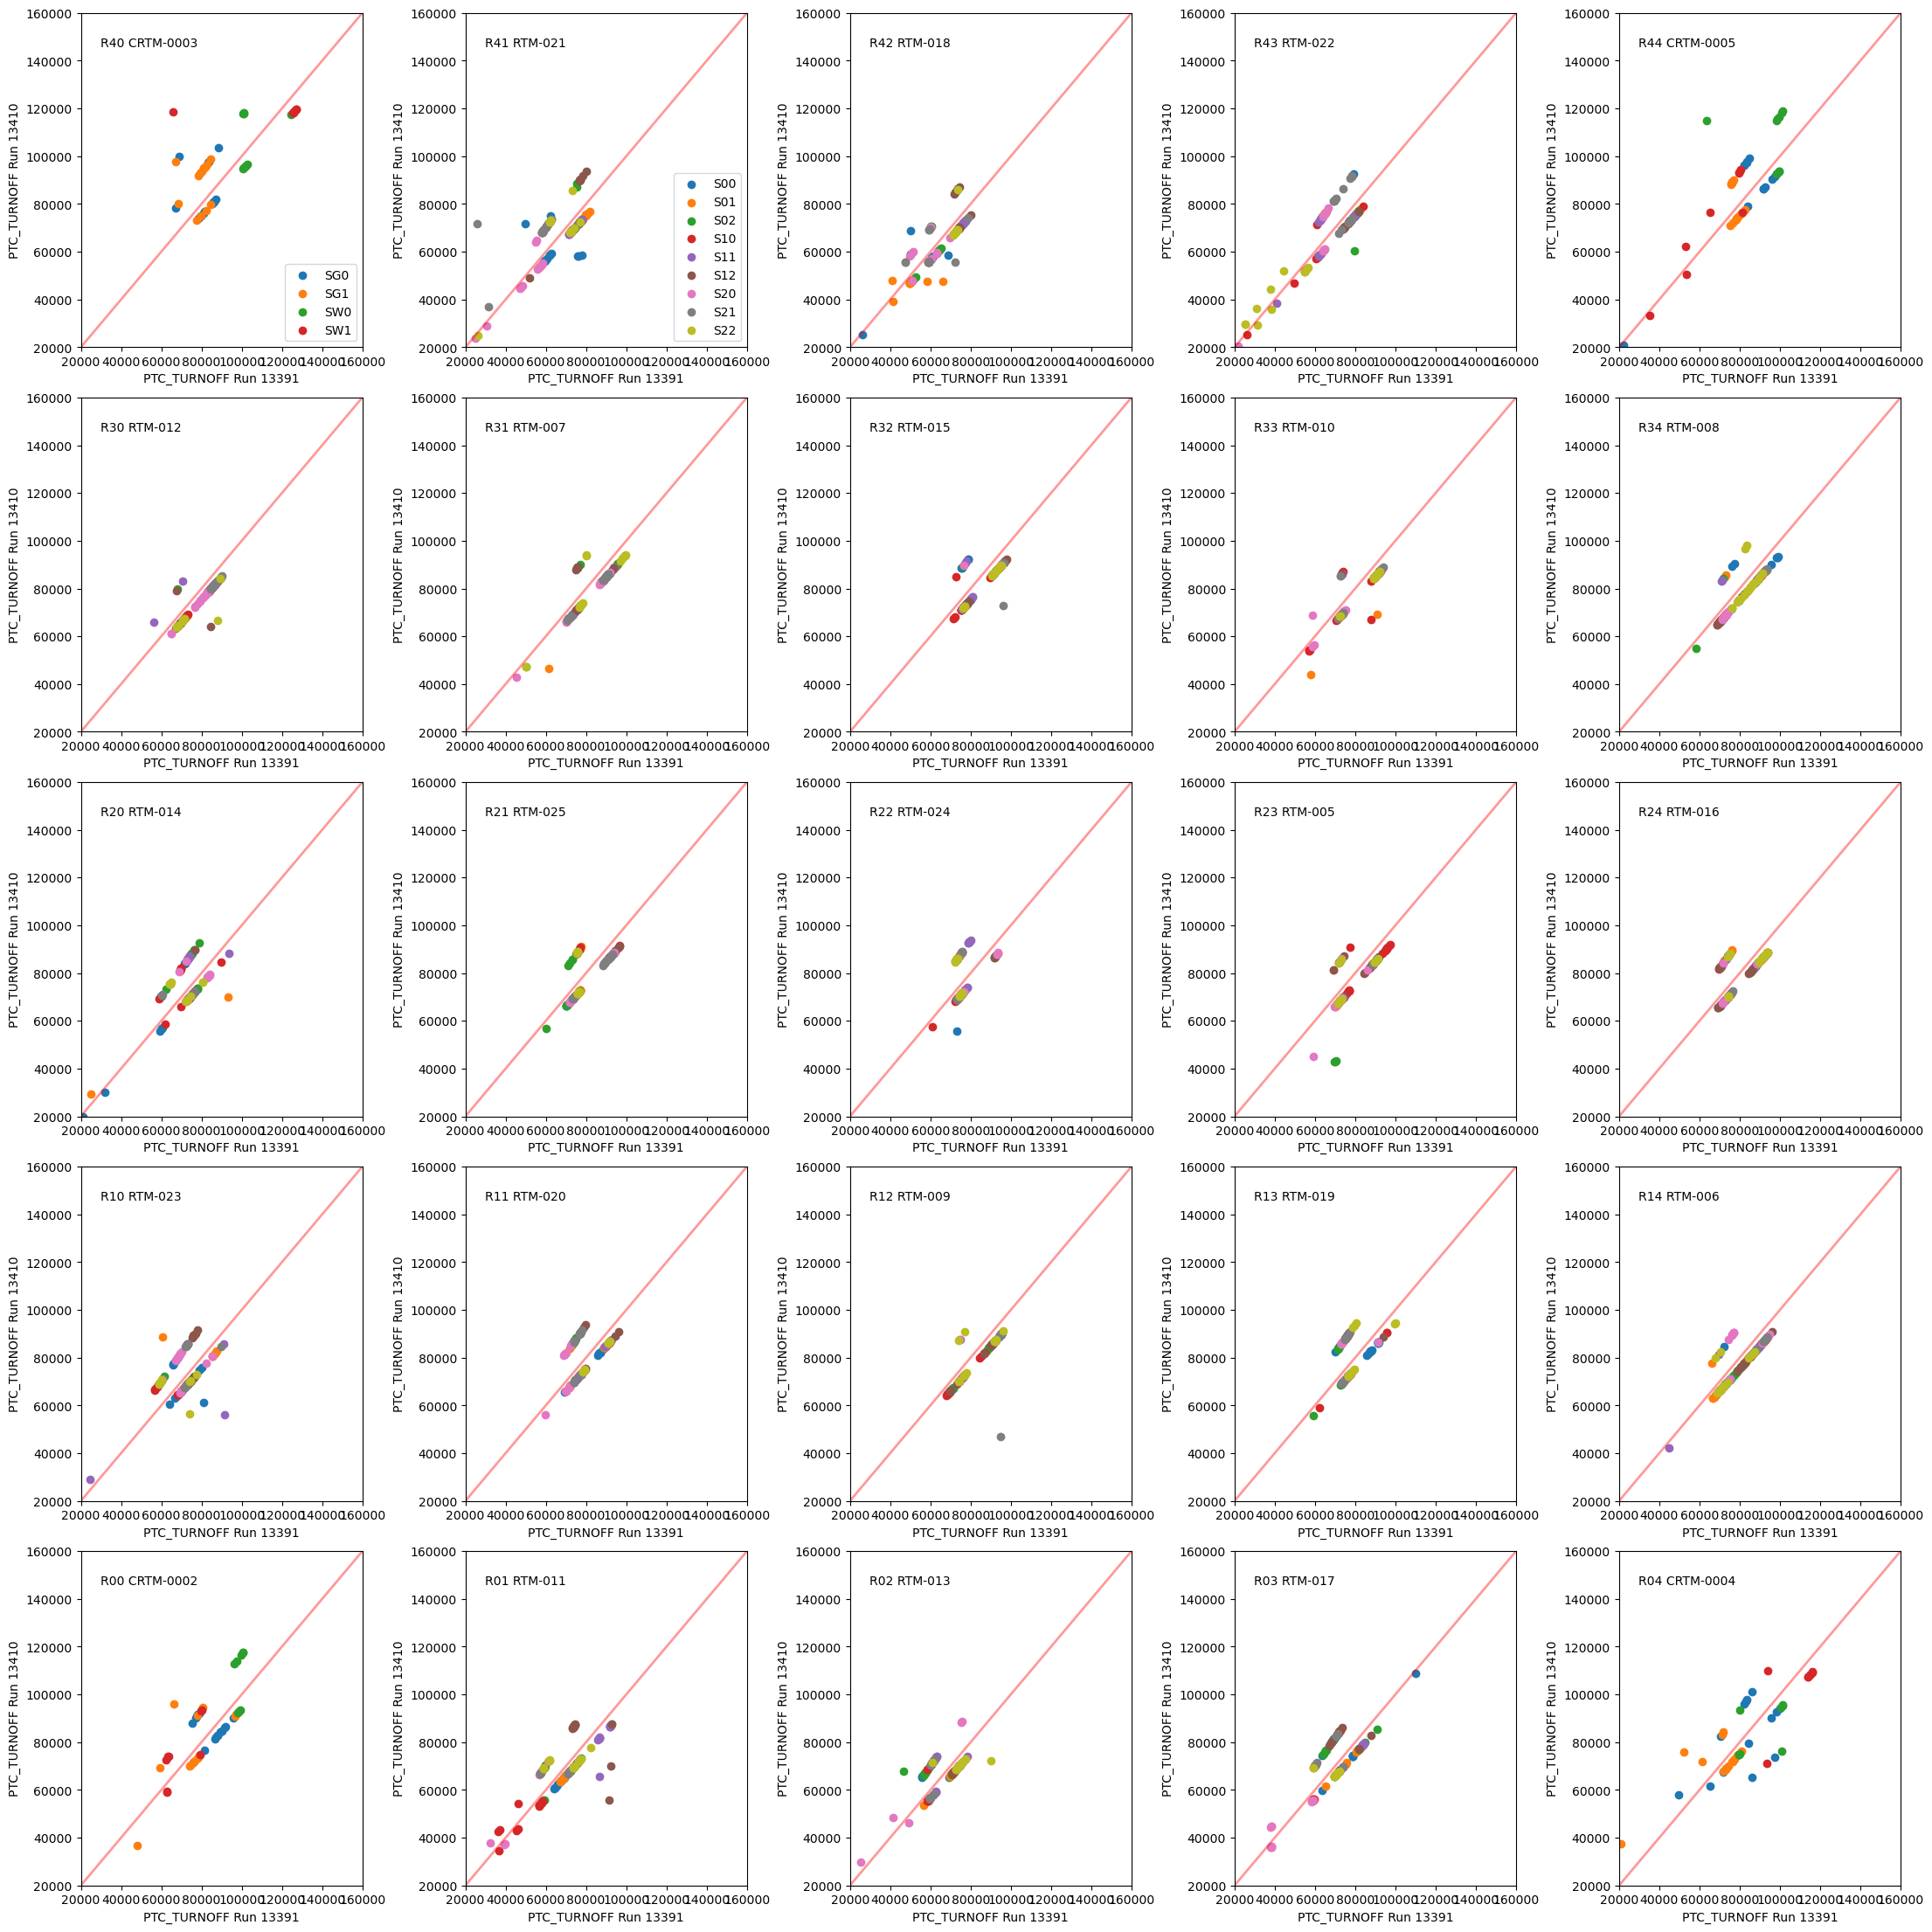

In [30]:
compare_tworuns(df_data_run1,df_data_run2,acq_run1,acq_run2,quantity='PTC_TURNOFF',minxy=2.0e4,maxxy=1.6e5,save='ptc_turnoff_%s_vs_%s'%(acq_run1,acq_run2))

In [32]:
badgain1 = (df_merge.PTC_GAIN_RUN1>2.0) | (df_merge.PTC_GAIN_RUN1<1.2) | (np.isnan(df_merge.PTC_GAIN_RUN1))
highnoise1 = (df_merge.READ_NOISE_RUN1>18.0)
lownoise1 = (df_merge.READ_NOISE_RUN1<4.5)

badgain2 = (df_merge.PTC_GAIN_RUN2>2.0) | (df_merge.PTC_GAIN_RUN2<1.2) | (np.isnan(df_merge.PTC_GAIN_RUN2))
highnoise2 = (df_merge.READ_NOISE_RUN2>18.0)
lownoise2 = (df_merge.READ_NOISE_RUN2<4.5)

bad = (badgain1 | badgain2 | highnoise1 | highnoise2 | lownoise1 | lownoise2)

print(tabulate(df_merge[bad][['BAY_SLOT','SEGMENT','READ_NOISE_RUN1','PTC_GAIN_RUN1','READ_NOISE_RUN2','PTC_GAIN_RUN2','COMMENT']],headers='keys',tablefmt='psql'))

+------+------------+-----------+-------------------+-----------------+-------------------+-----------------+------------------------------+
|      | BAY_SLOT   | SEGMENT   |   READ_NOISE_RUN1 |   PTC_GAIN_RUN1 |   READ_NOISE_RUN2 |   PTC_GAIN_RUN2 | COMMENT                      |
|------+------------+-----------+-------------------+-----------------+-------------------+-----------------+------------------------------|
|   79 | R01_S01    | C00       |         43.3449   |      14.5068    |           6.08847 |        1.6551   | Formerly Dead, Alive in Run5 |
|  415 | R03_S11    | C00       |         33.5159   |      11.7085    |          45.147   |       15.7955   | Dead Channel                 |
|  481 | R04_SG0    | C11       |          0.499504 |       0.0407857 |           1.793   |        0.145928 | Dead Channel                 |
| 1968 | R30_S00    | C10       |        nan        |     nan         |         nan       |      nan        | Dead Channel                 |
| 2704 | R40_

# Linearity

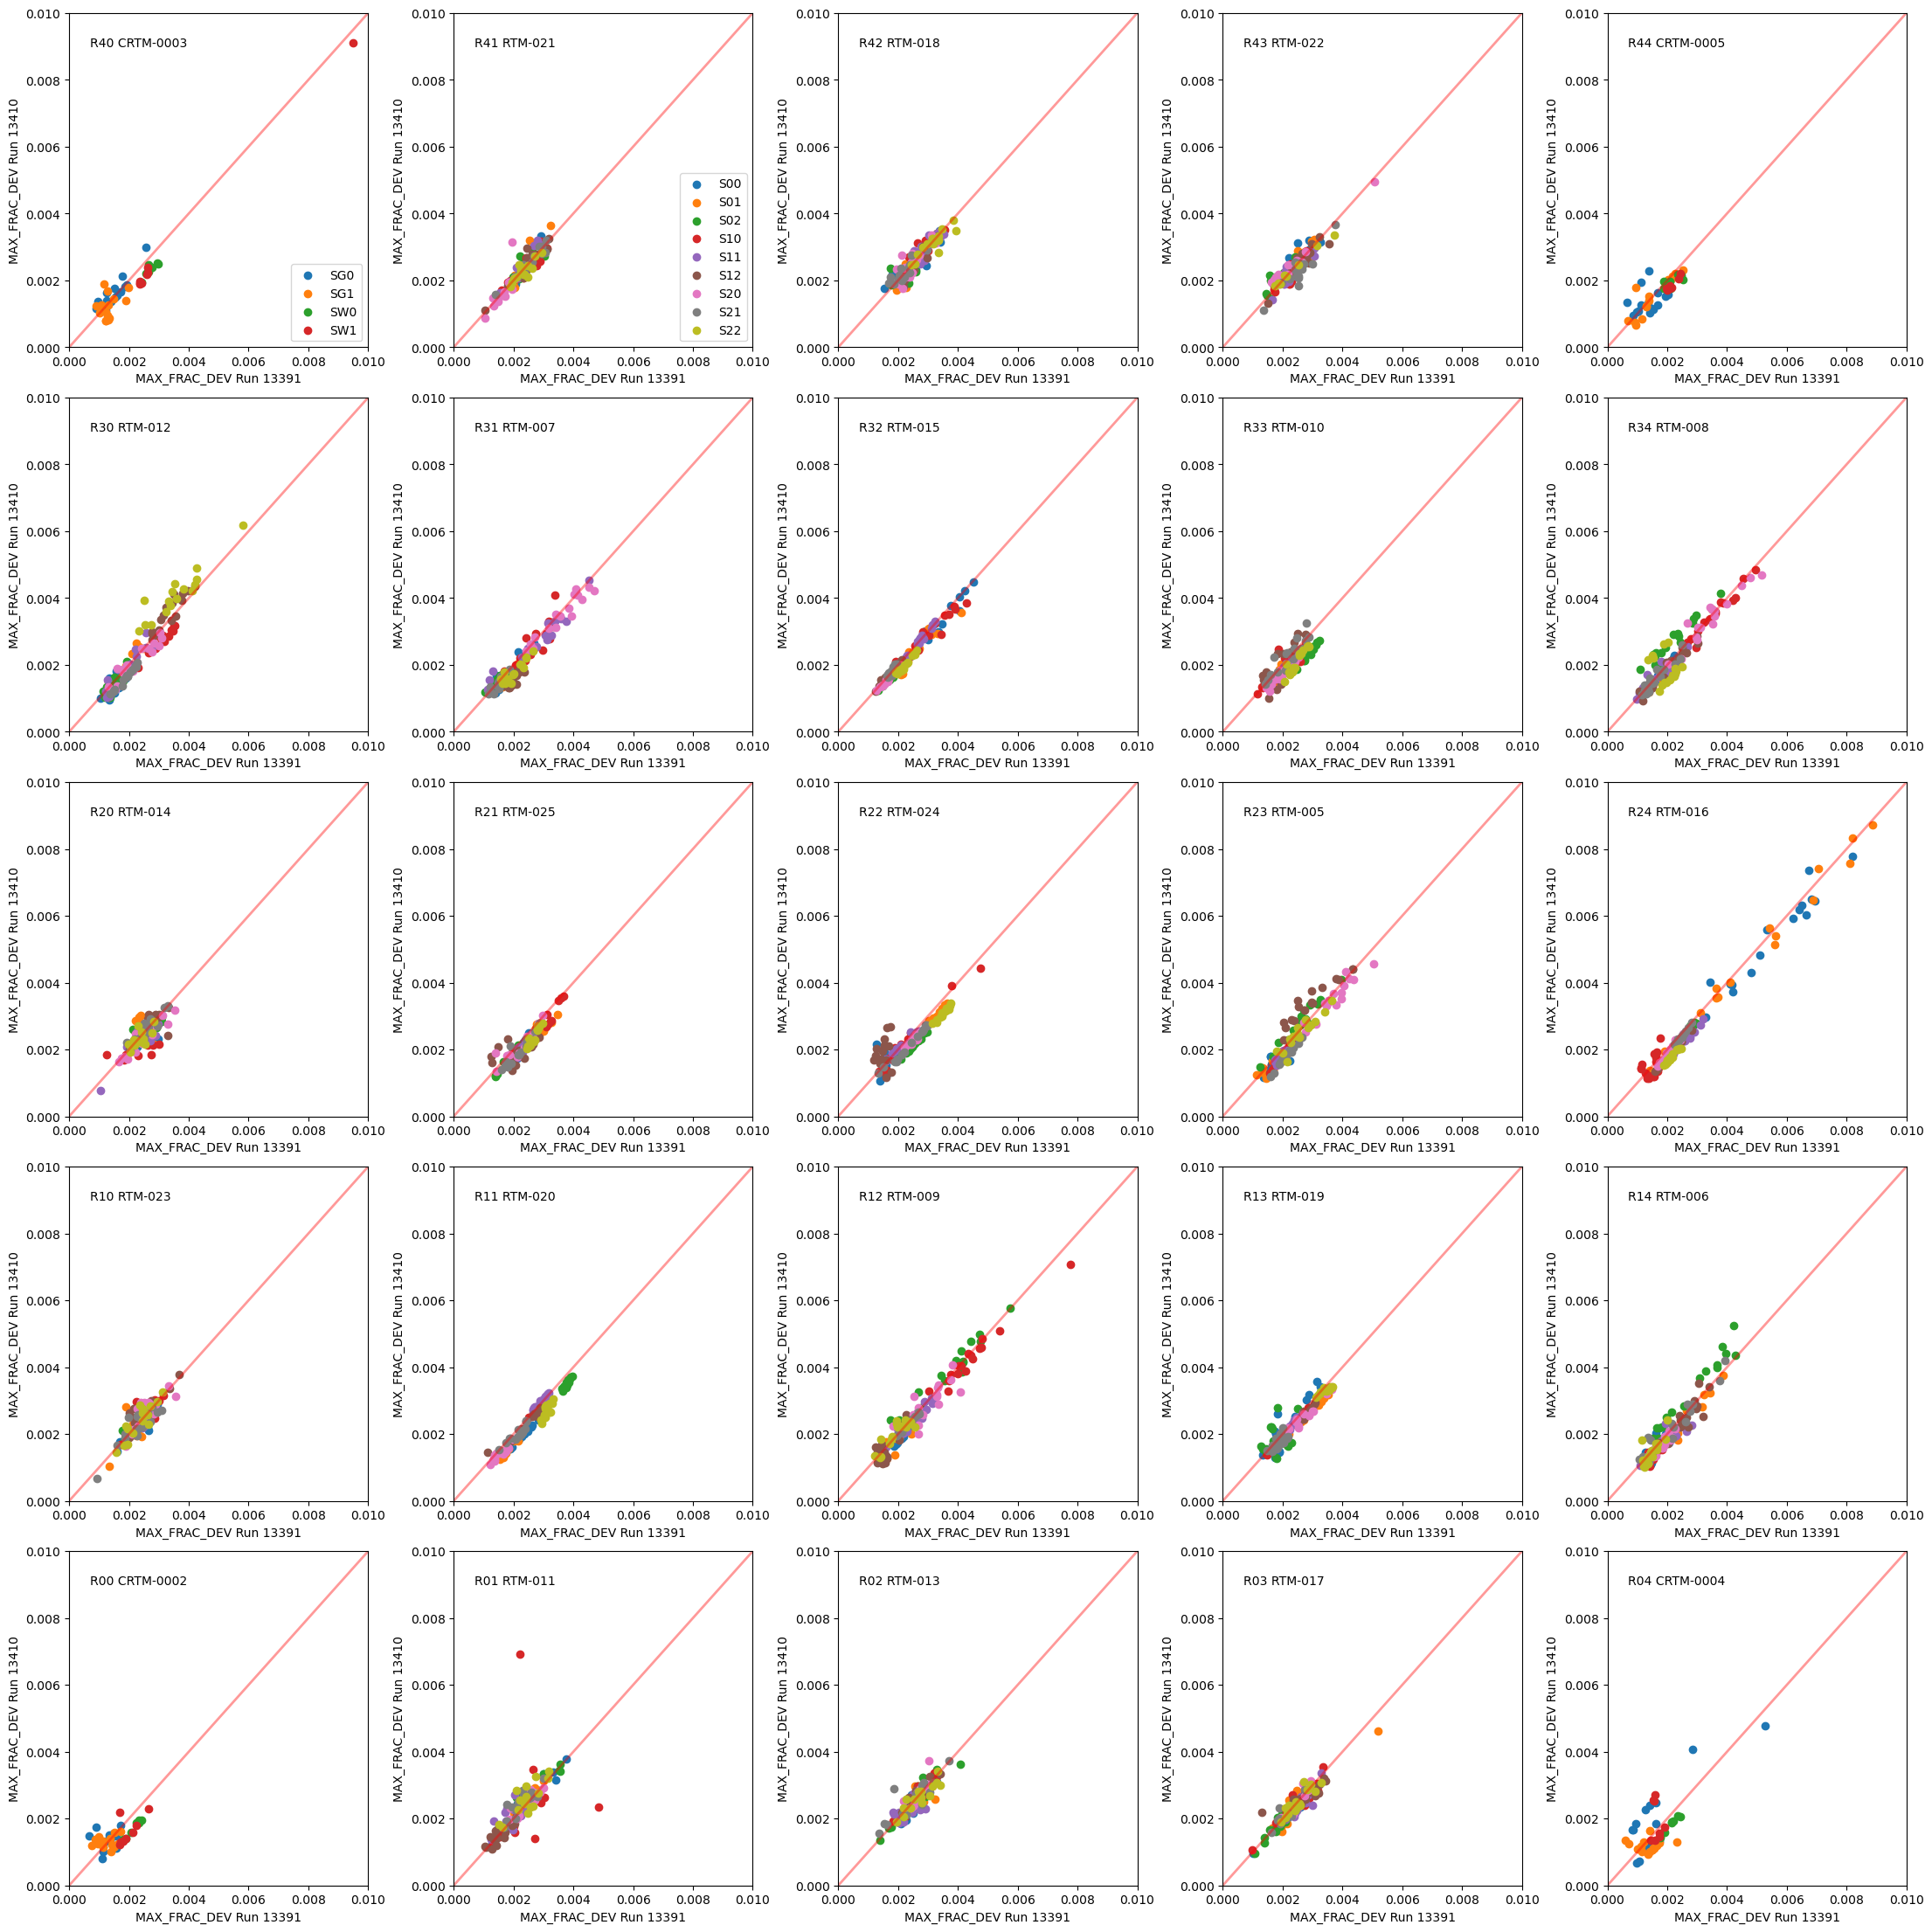

In [33]:
compare_tworuns(df_data_run1,df_data_run2,acq_run1,acq_run2,quantity='MAX_FRAC_DEV',minxy=0.0,maxxy=0.01,save='maxfracdev_%s_vs_%s'%(acq_run1,acq_run2))

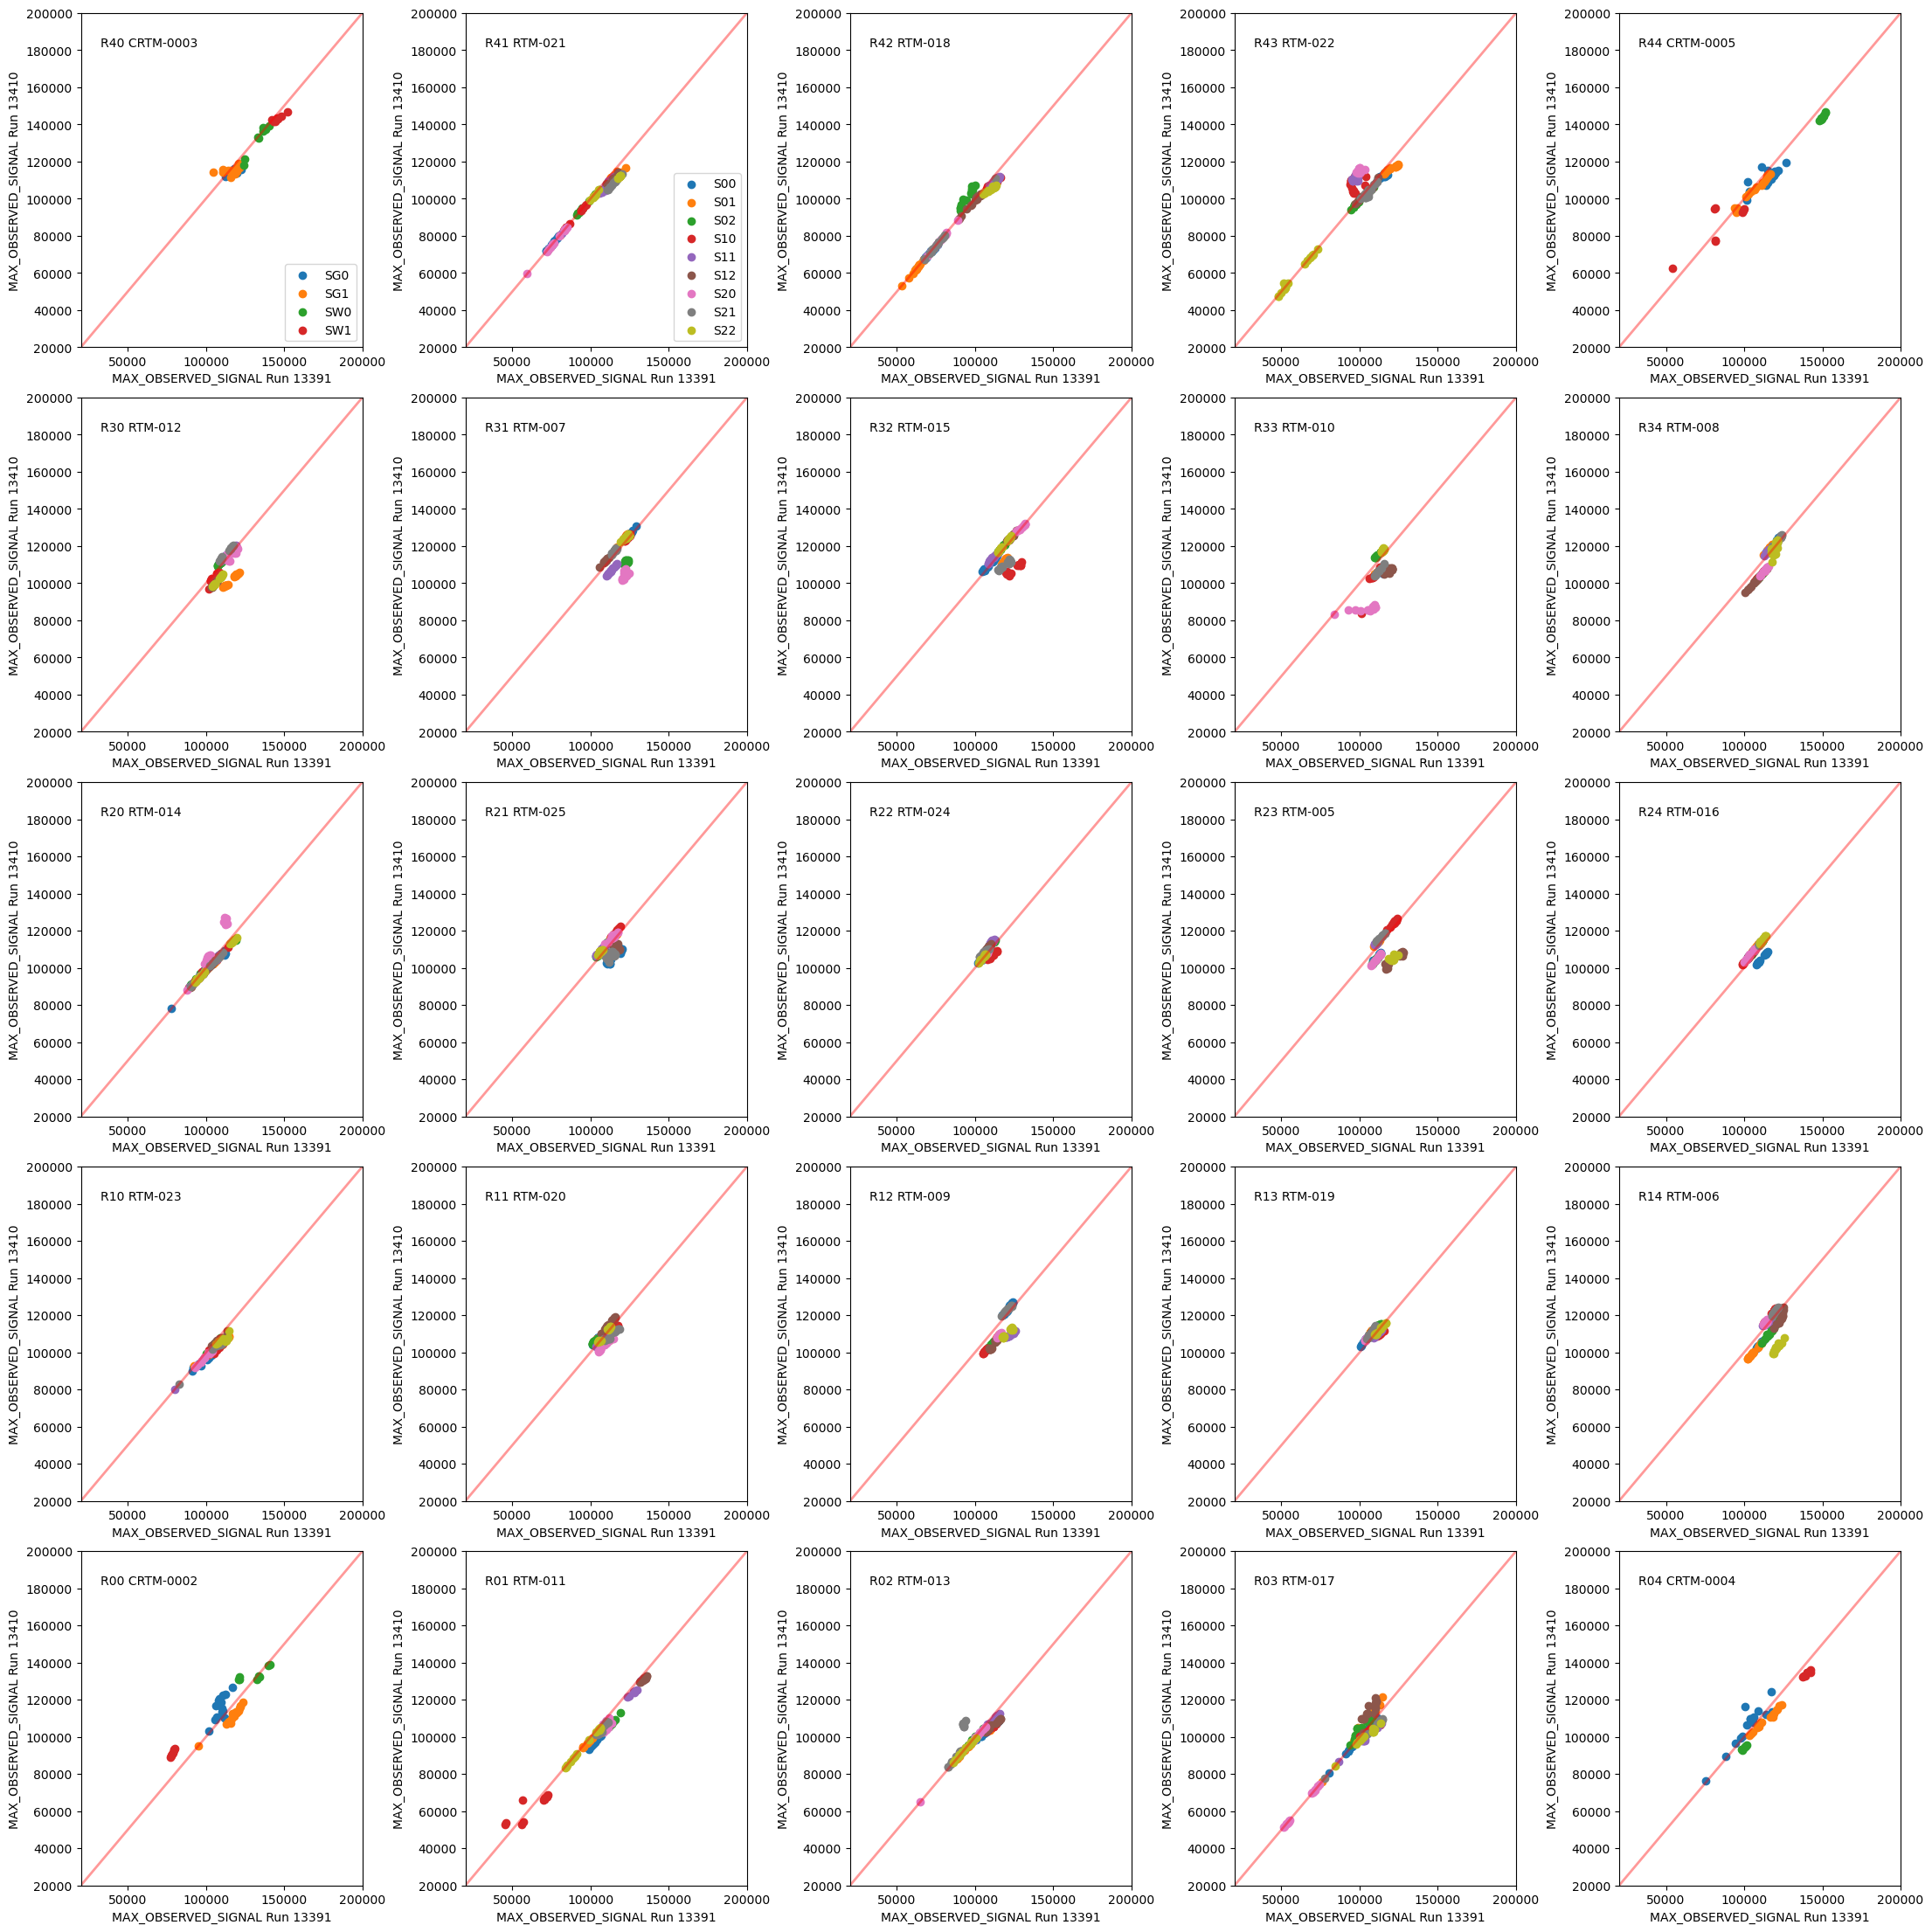

In [34]:
compare_tworuns(df_data_run1,df_data_run2,acq_run1,acq_run2,quantity='MAX_OBSERVED_SIGNAL',minxy=2.0e4,maxxy=2.0e5,save='maxobssignal_%s_vs_%s'%(acq_run1,acq_run2))

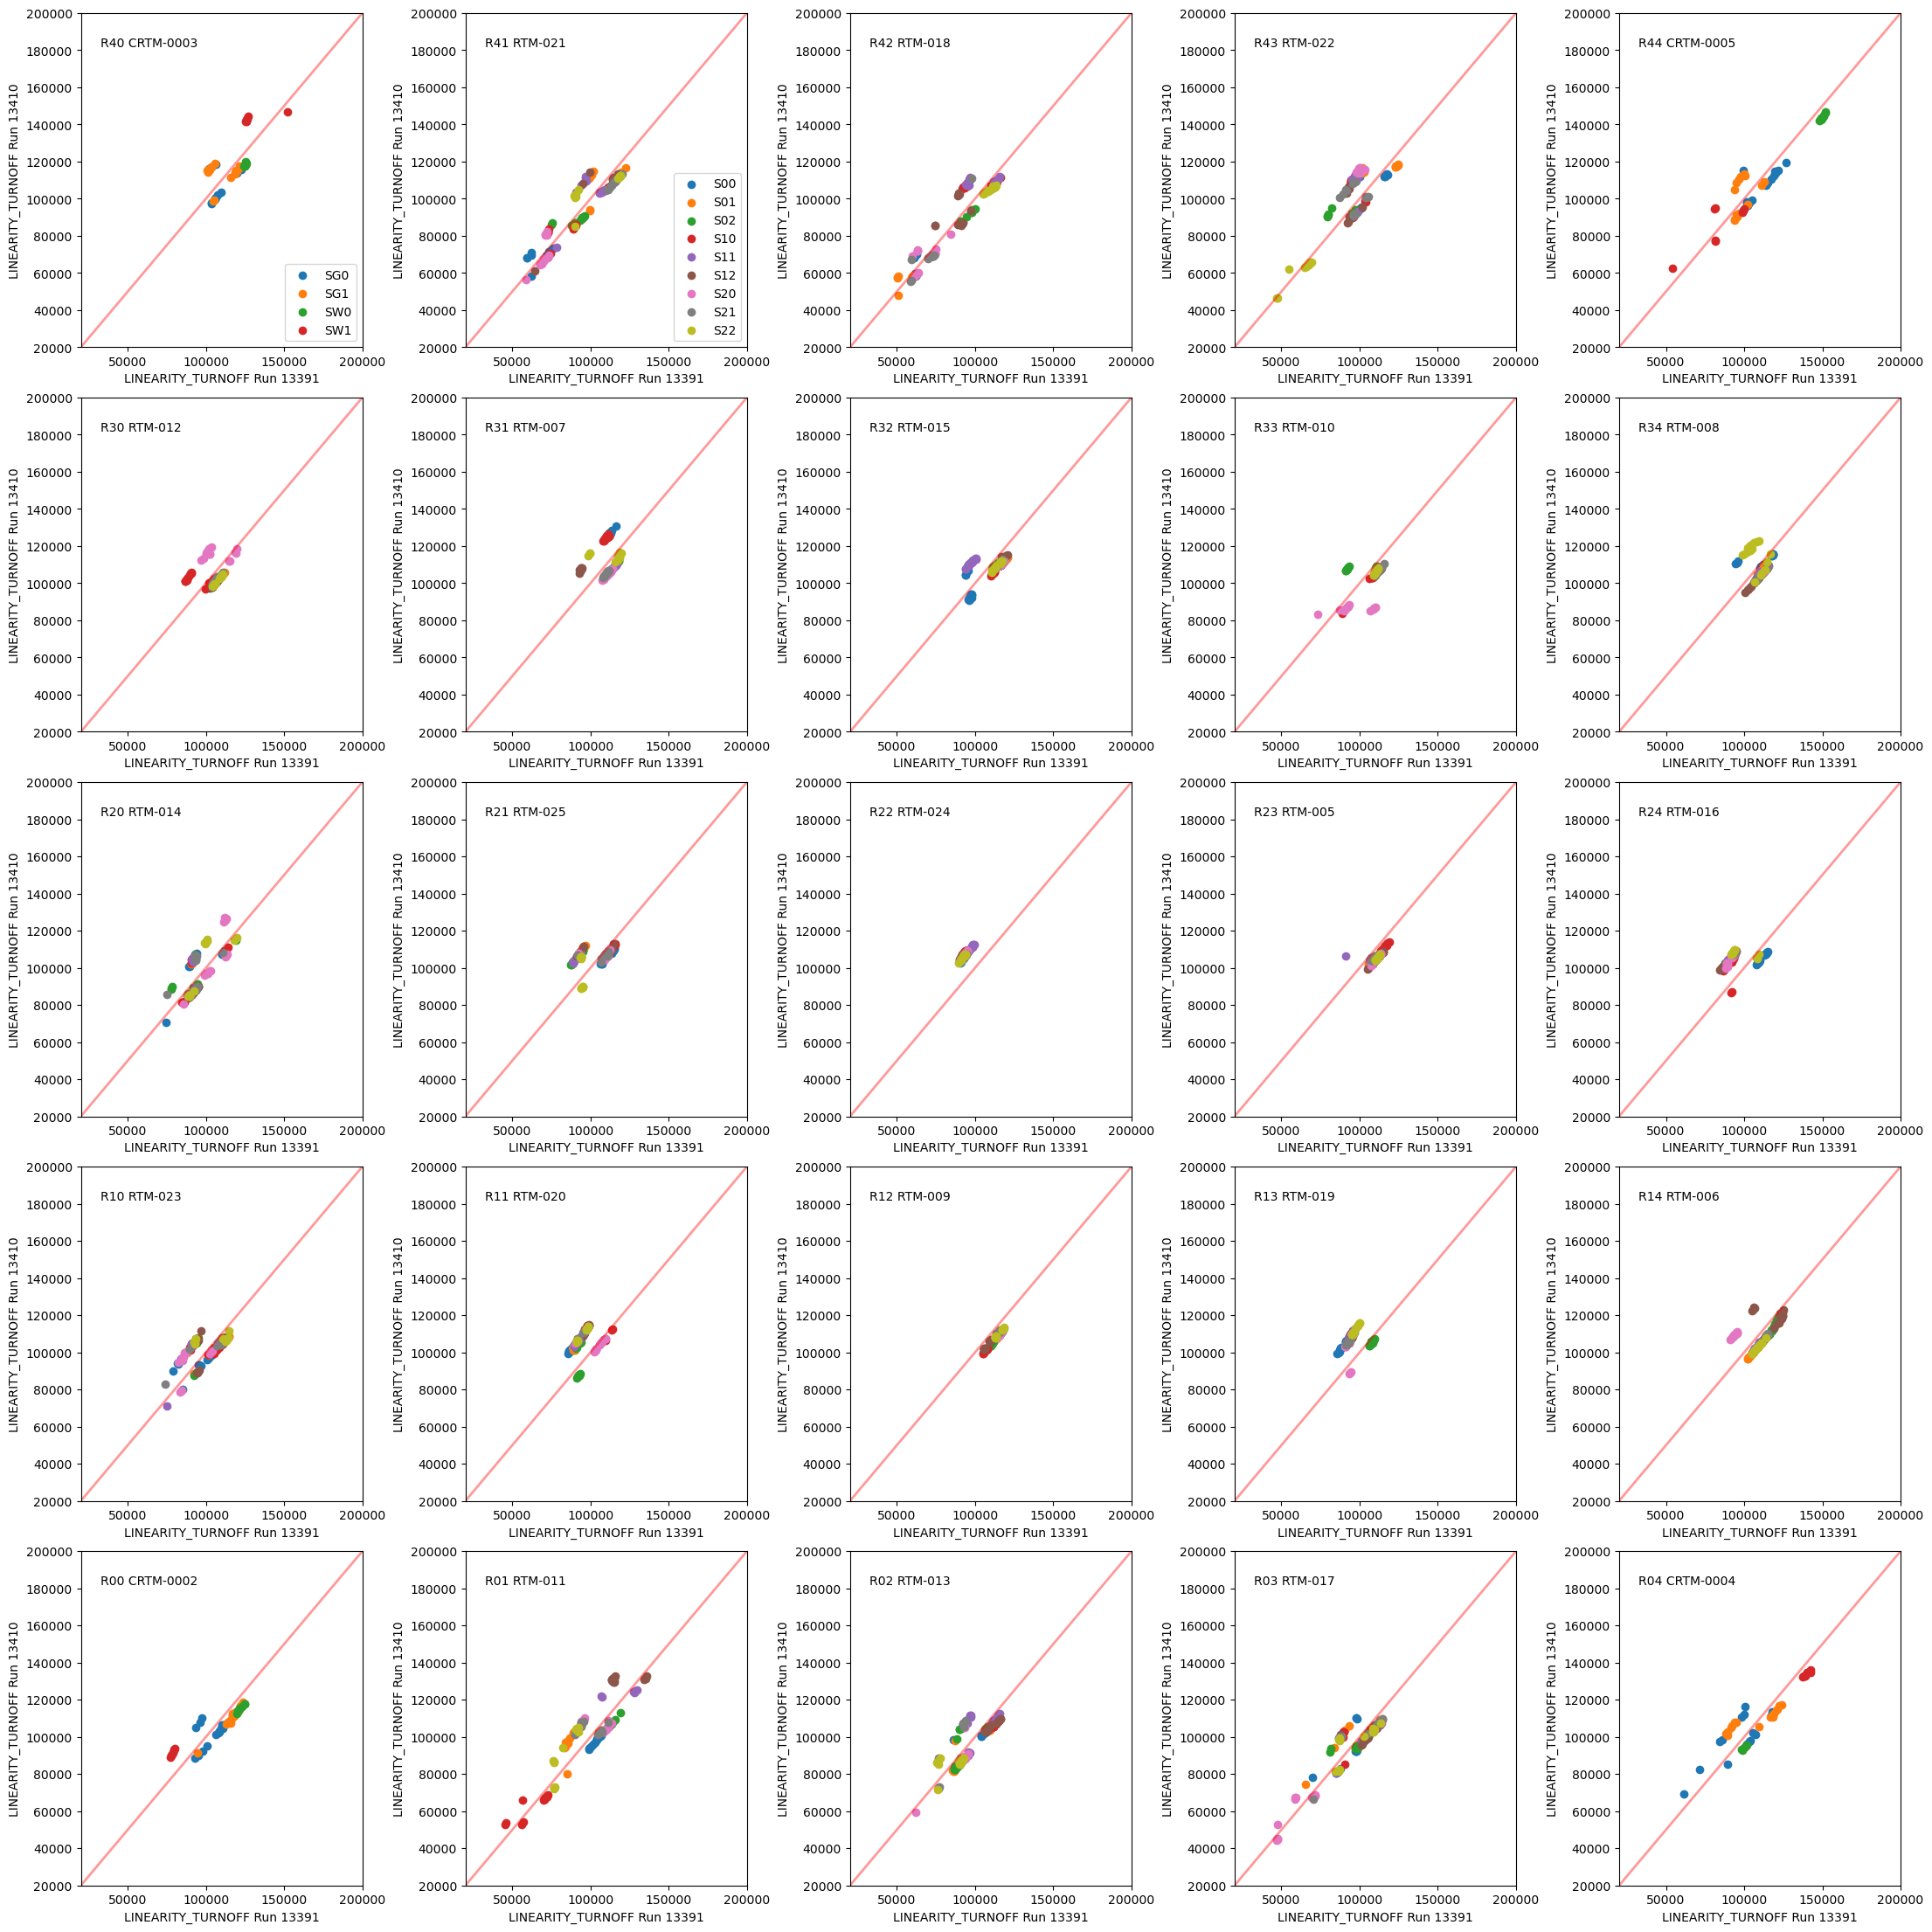

In [35]:
compare_tworuns(df_data_run1,df_data_run2,acq_run1,acq_run2,quantity='LINEARITY_TURNOFF',minxy=2.0e4,maxxy=2.0e5,save='linearity_turnoff_%s_vs_%s'%(acq_run1,acq_run2))

# CTI Serial and Parallel

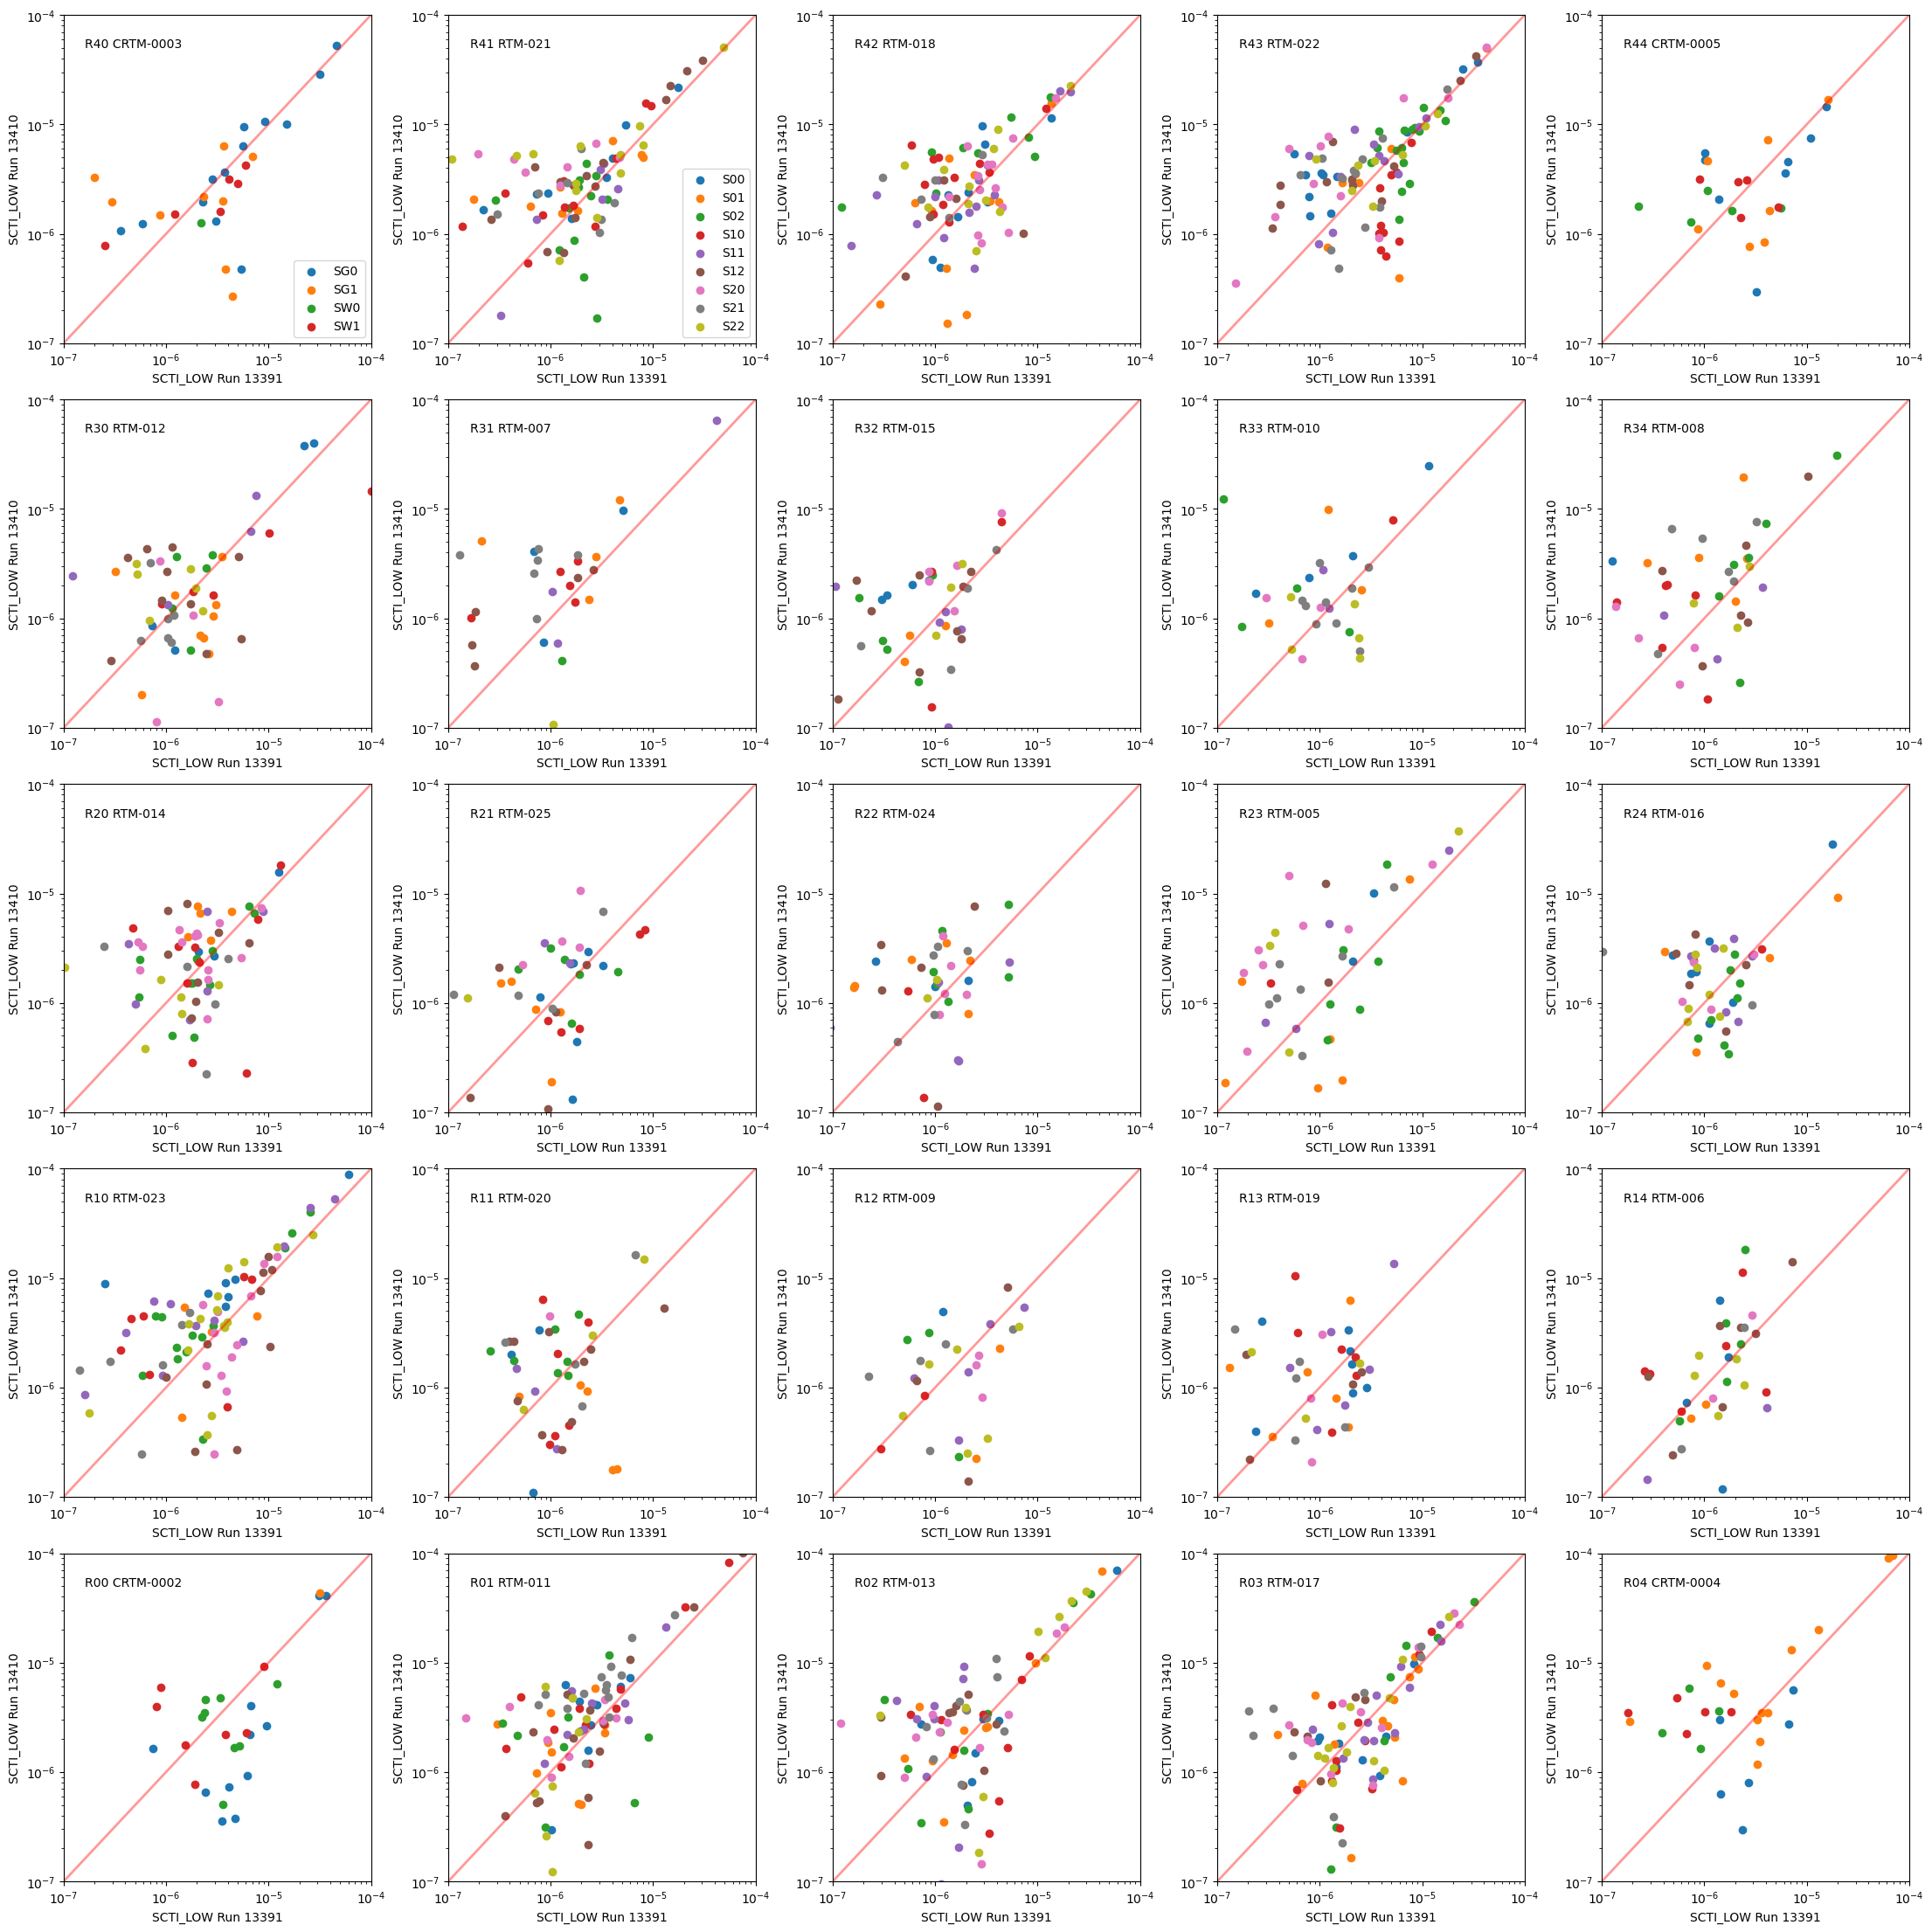

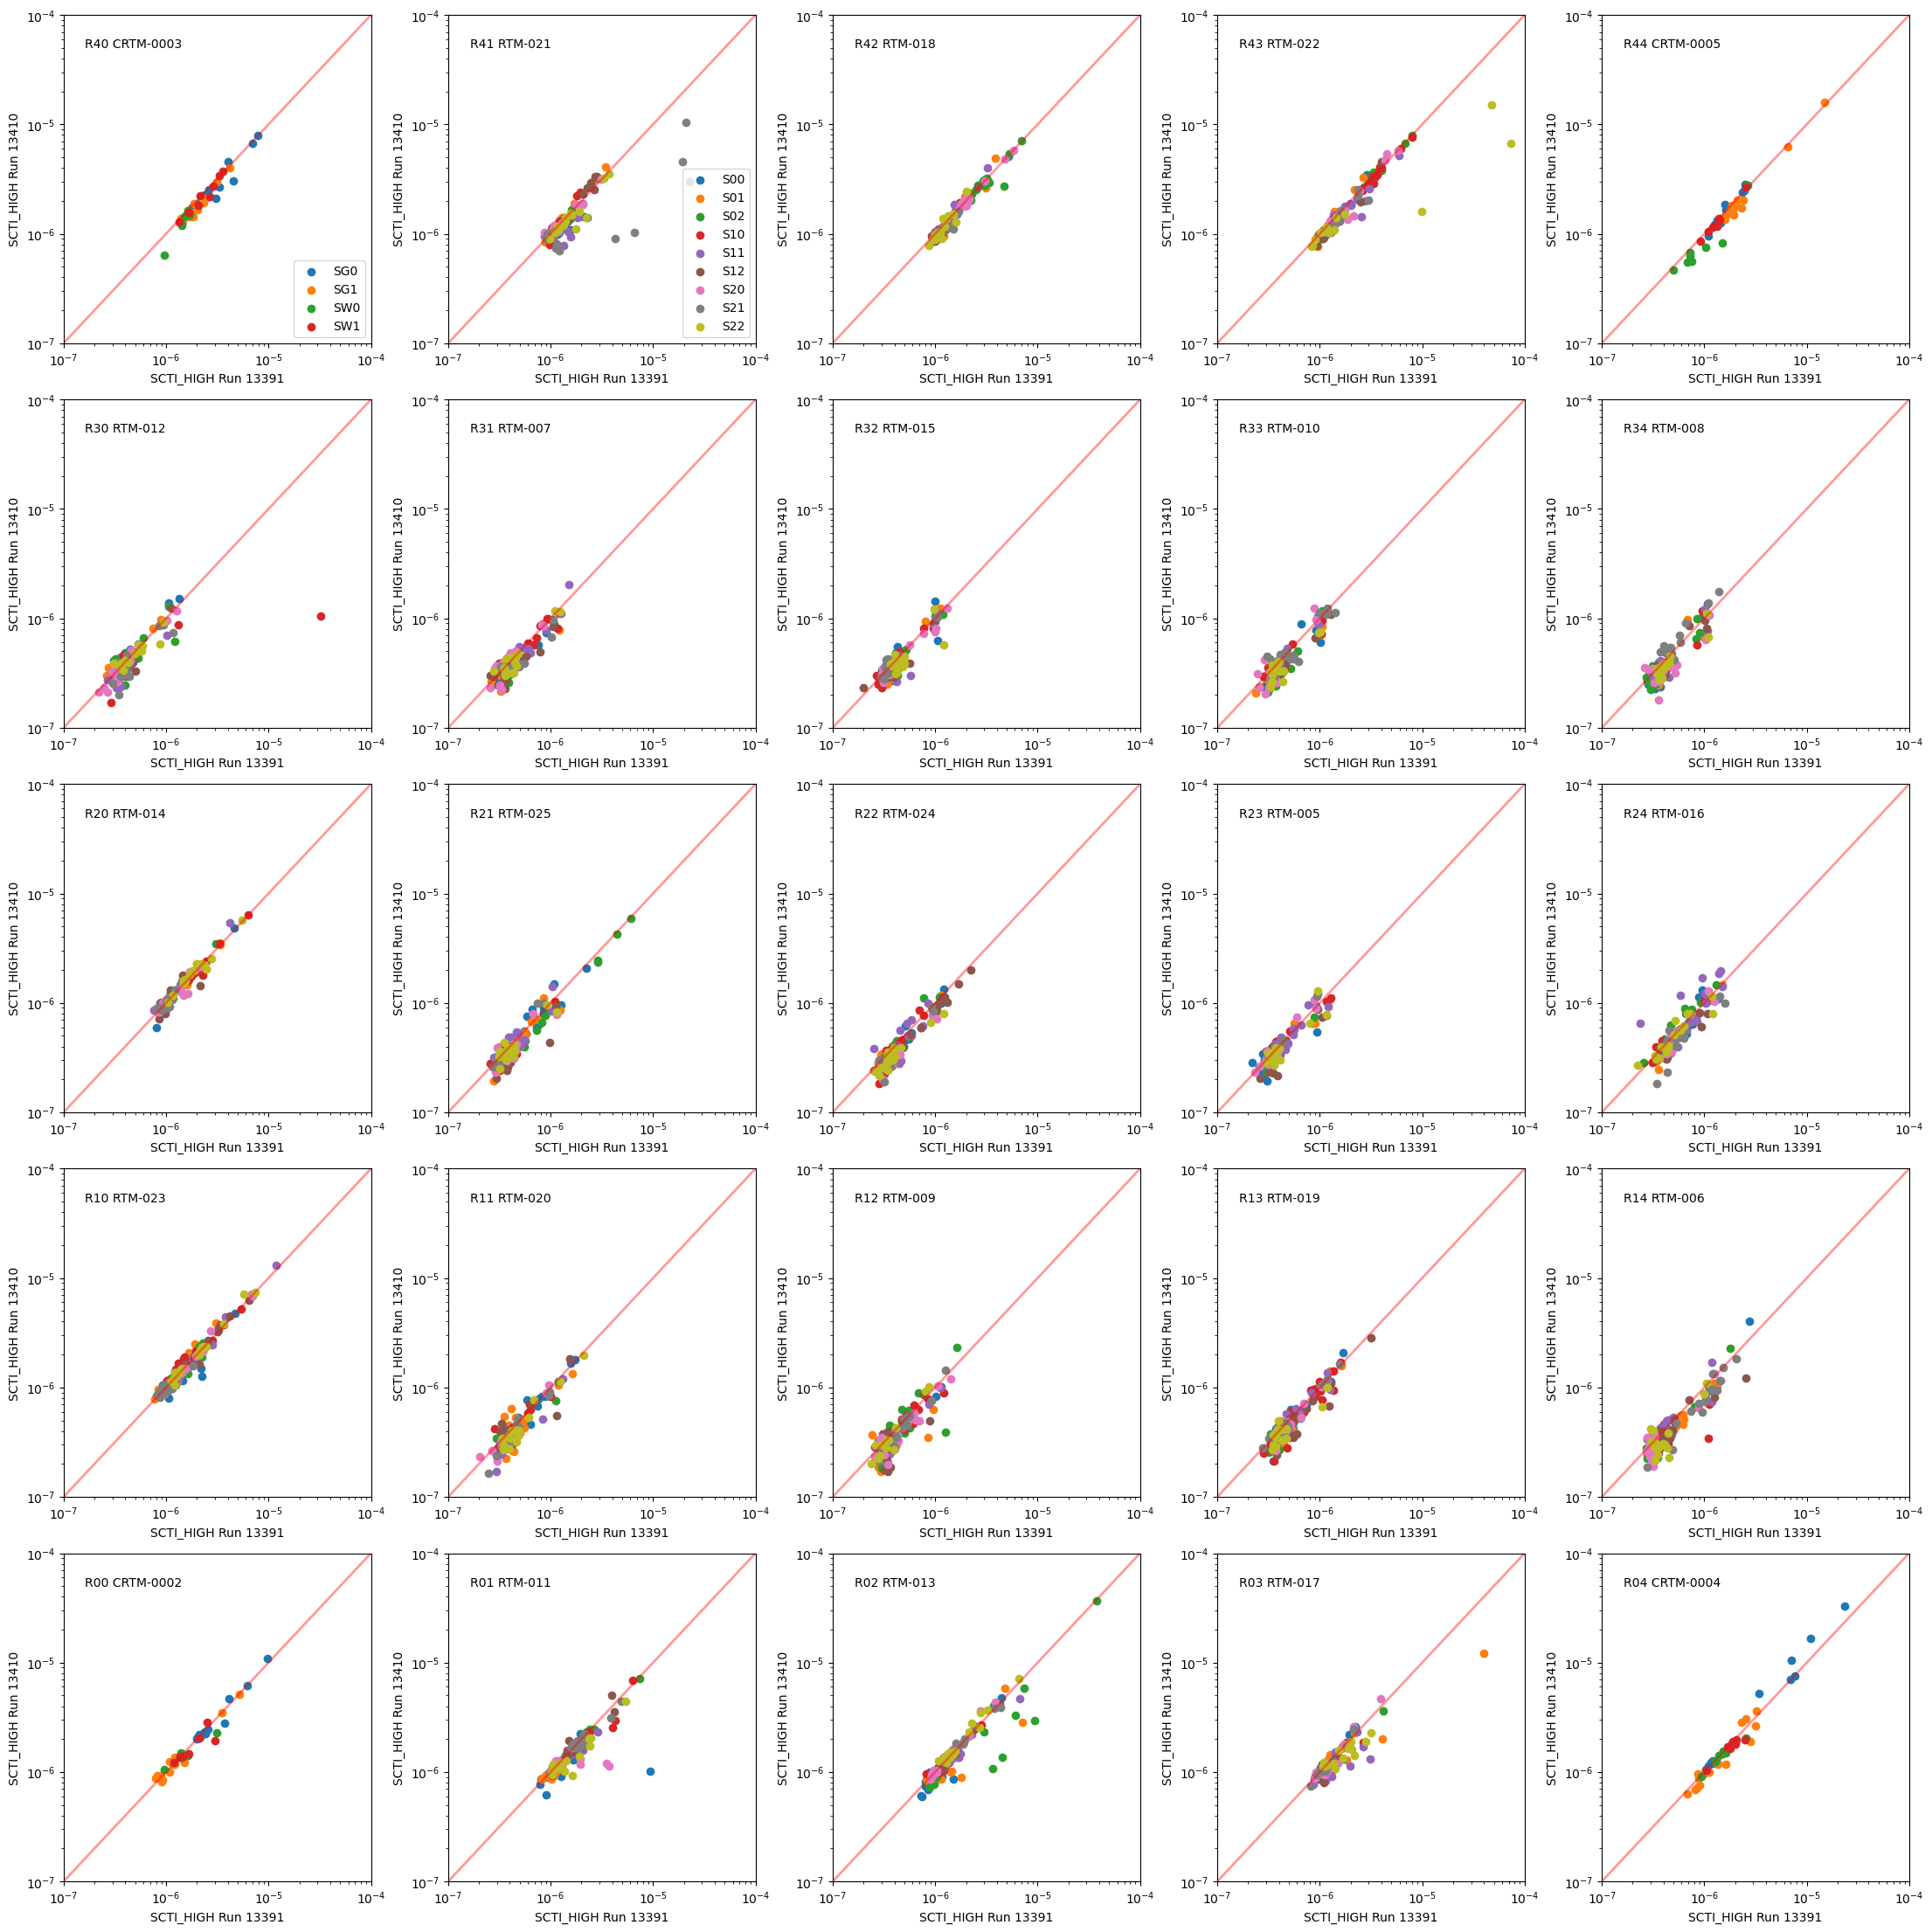

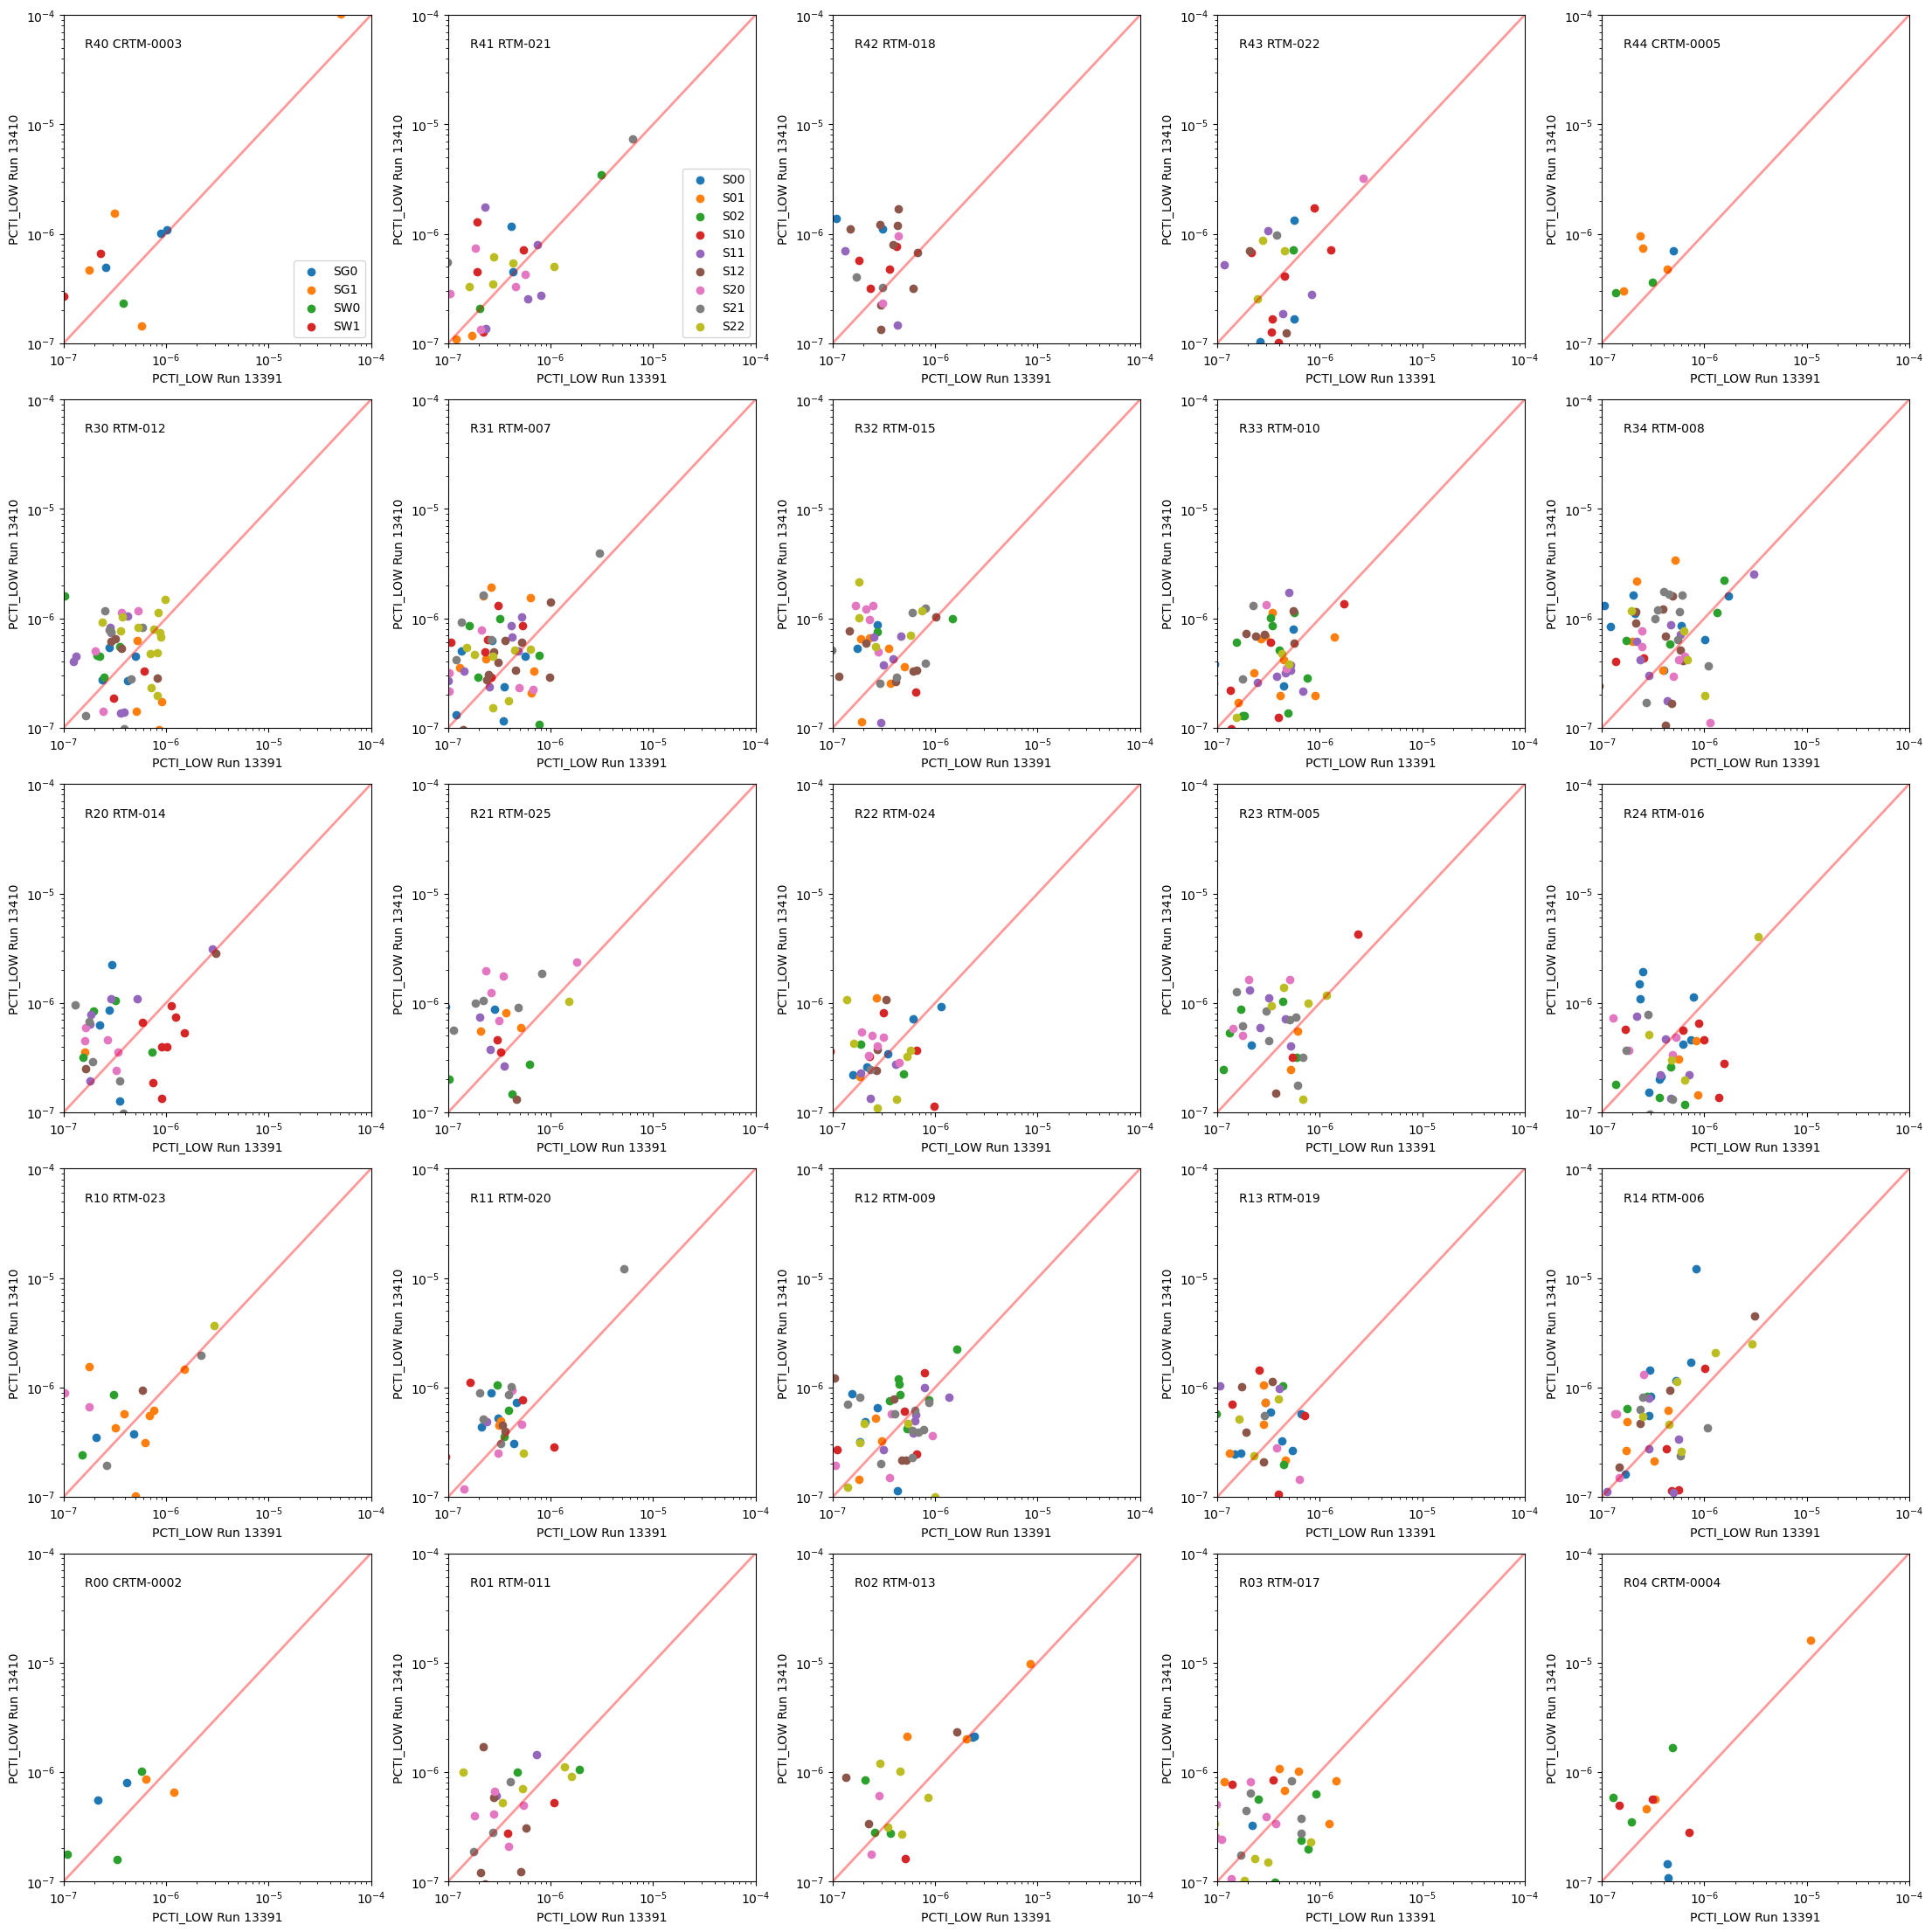

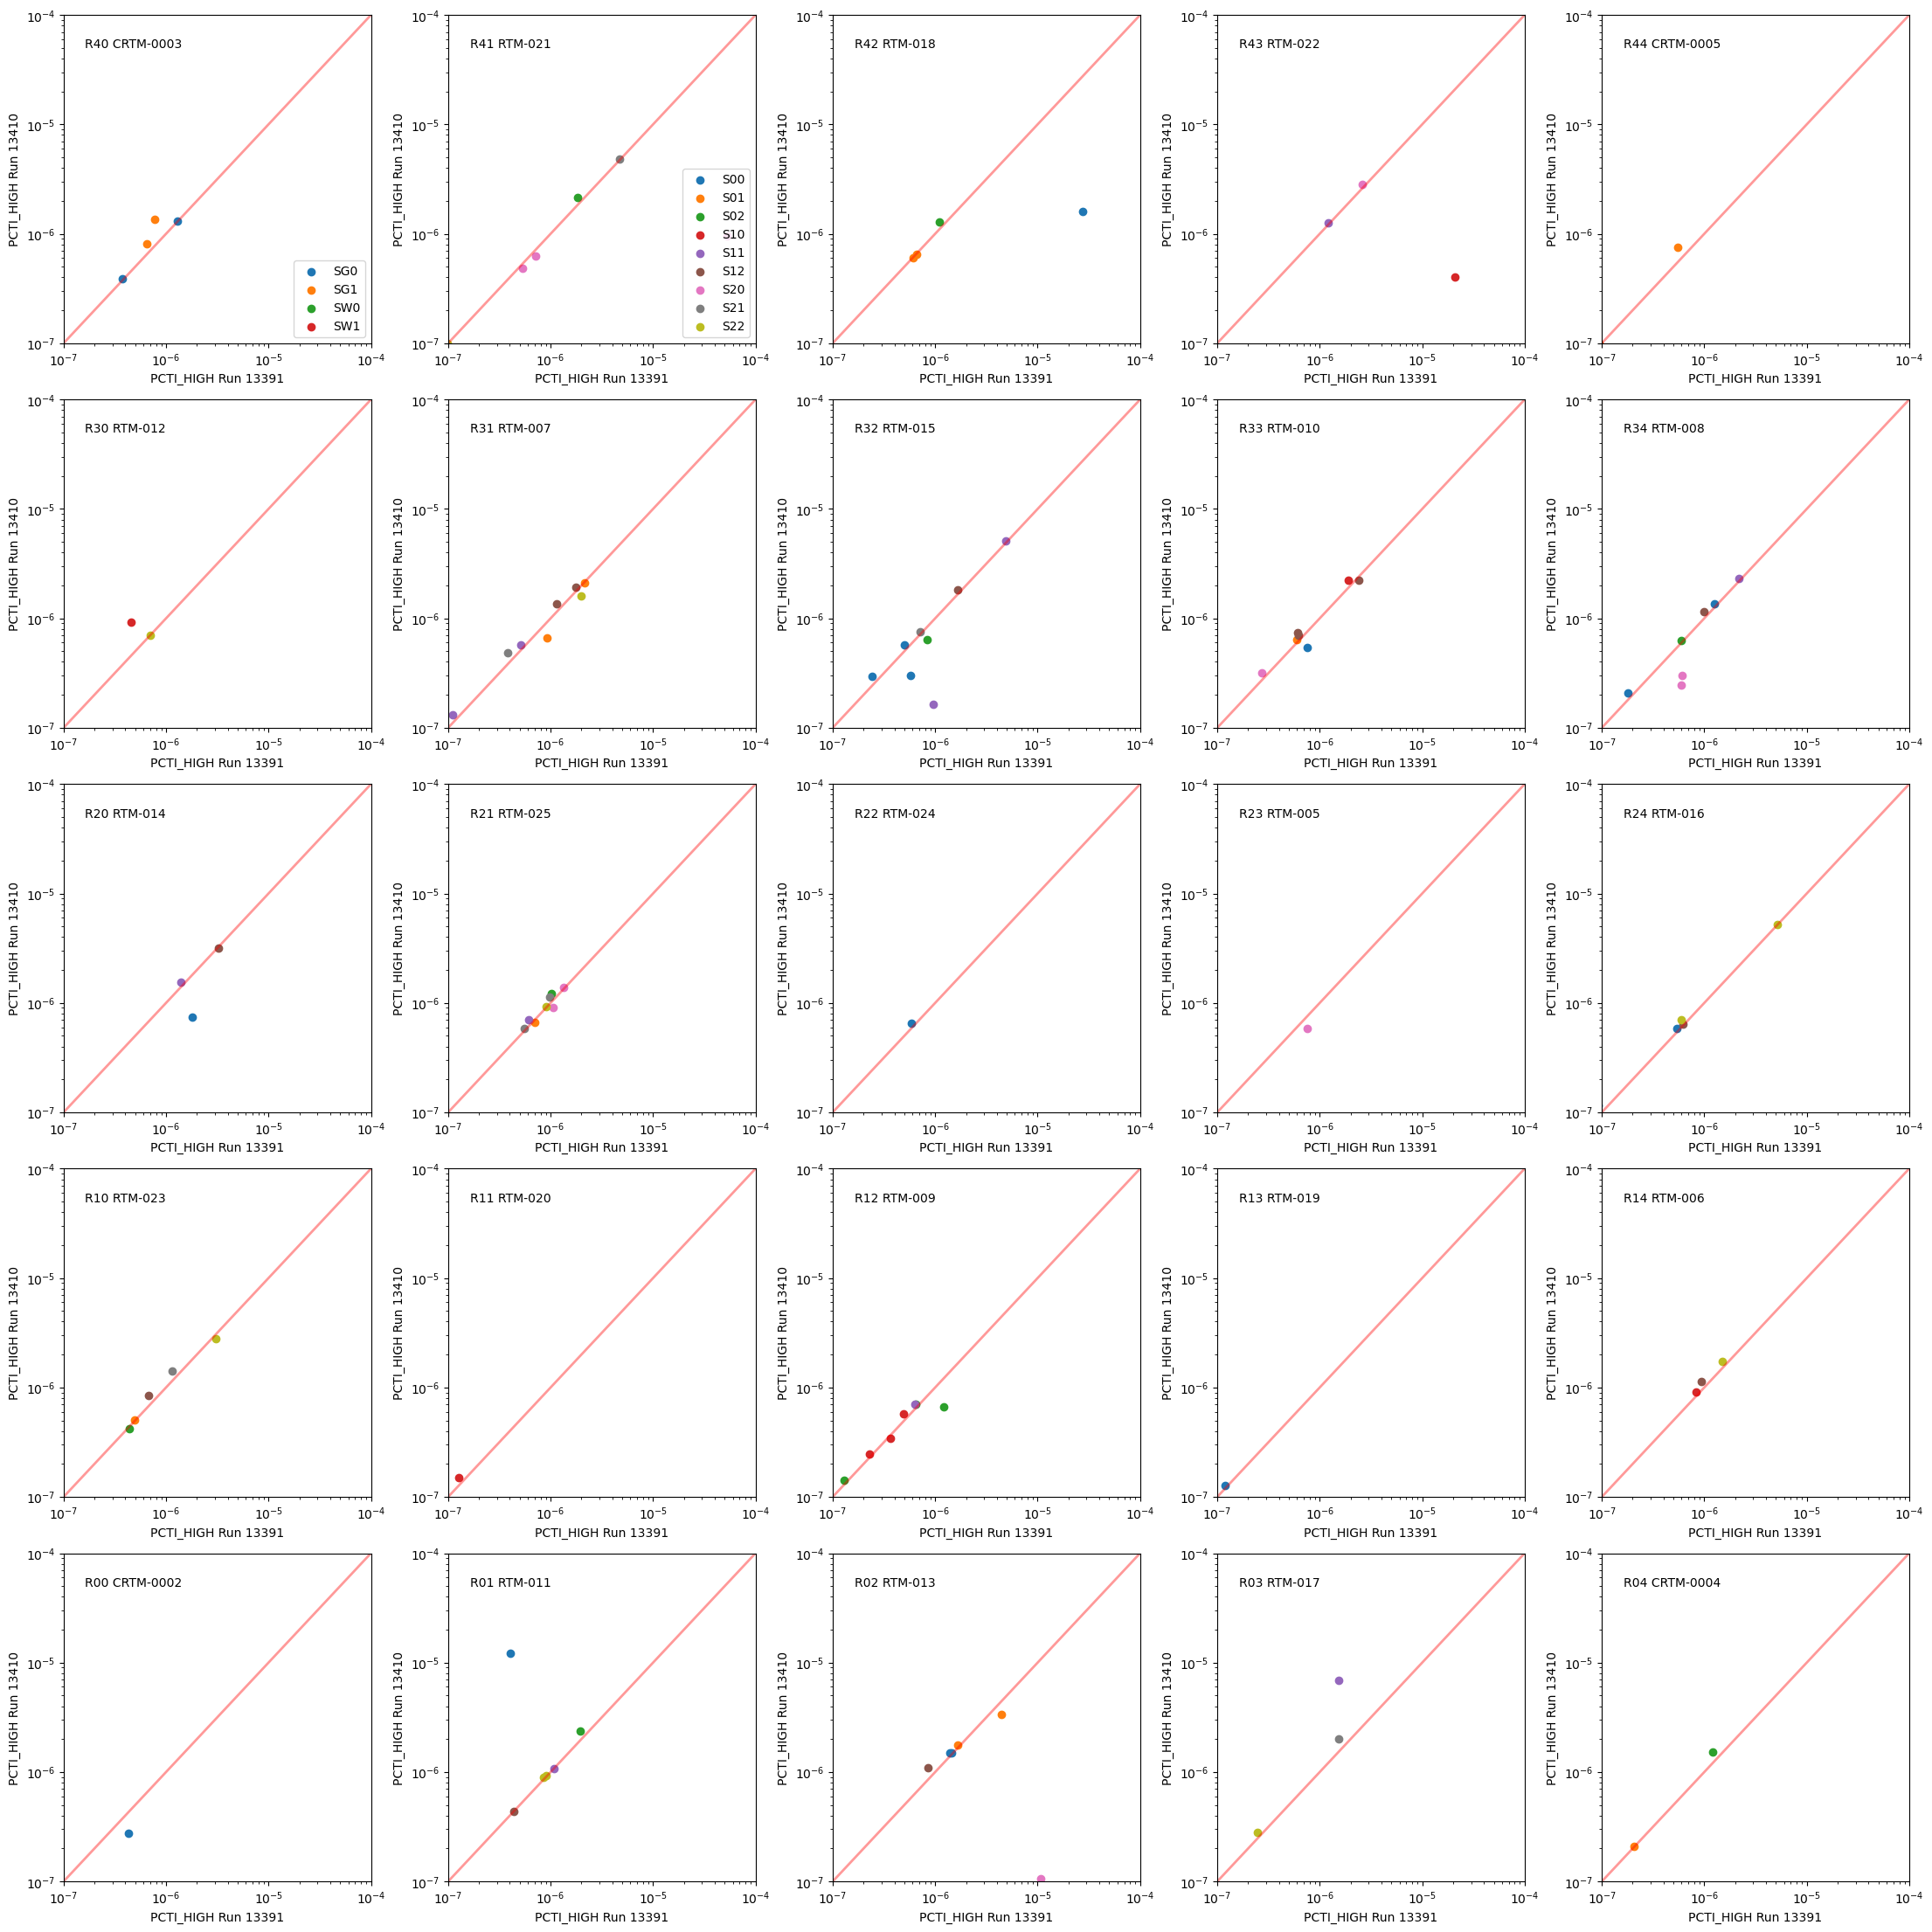

In [37]:
compare_tworuns(df_data_run1,df_data_run2,acq_run1,acq_run2,quantity='SCTI_LOW',minxy=1.0e-7,maxxy=1.0e-4,scale='log',save='scti_low_%s_vs_%s'%(acq_run1,acq_run2))
compare_tworuns(df_data_run1,df_data_run2,acq_run1,acq_run2,quantity='SCTI_HIGH',minxy=1.0e-7,maxxy=1.0e-4,scale='log',save='scti_high_%s_vs_%s'%(acq_run1,acq_run2))
compare_tworuns(df_data_run1,df_data_run2,acq_run1,acq_run2,quantity='PCTI_LOW',minxy=1.0e-7,maxxy=1.0e-4,scale='log',save='pcti_low_%s_vs_%s'%(acq_run1,acq_run2))
compare_tworuns(df_data_run1,df_data_run2,acq_run1,acq_run2,quantity='PCTI_HIGH',minxy=1.0e-7,maxxy=1.0e-4,scale='log',save='pcti_high_%s_vs_%s'%(acq_run1,acq_run2))


In [ ]:
# check on PCTI_HIGH values?

# Divisidero

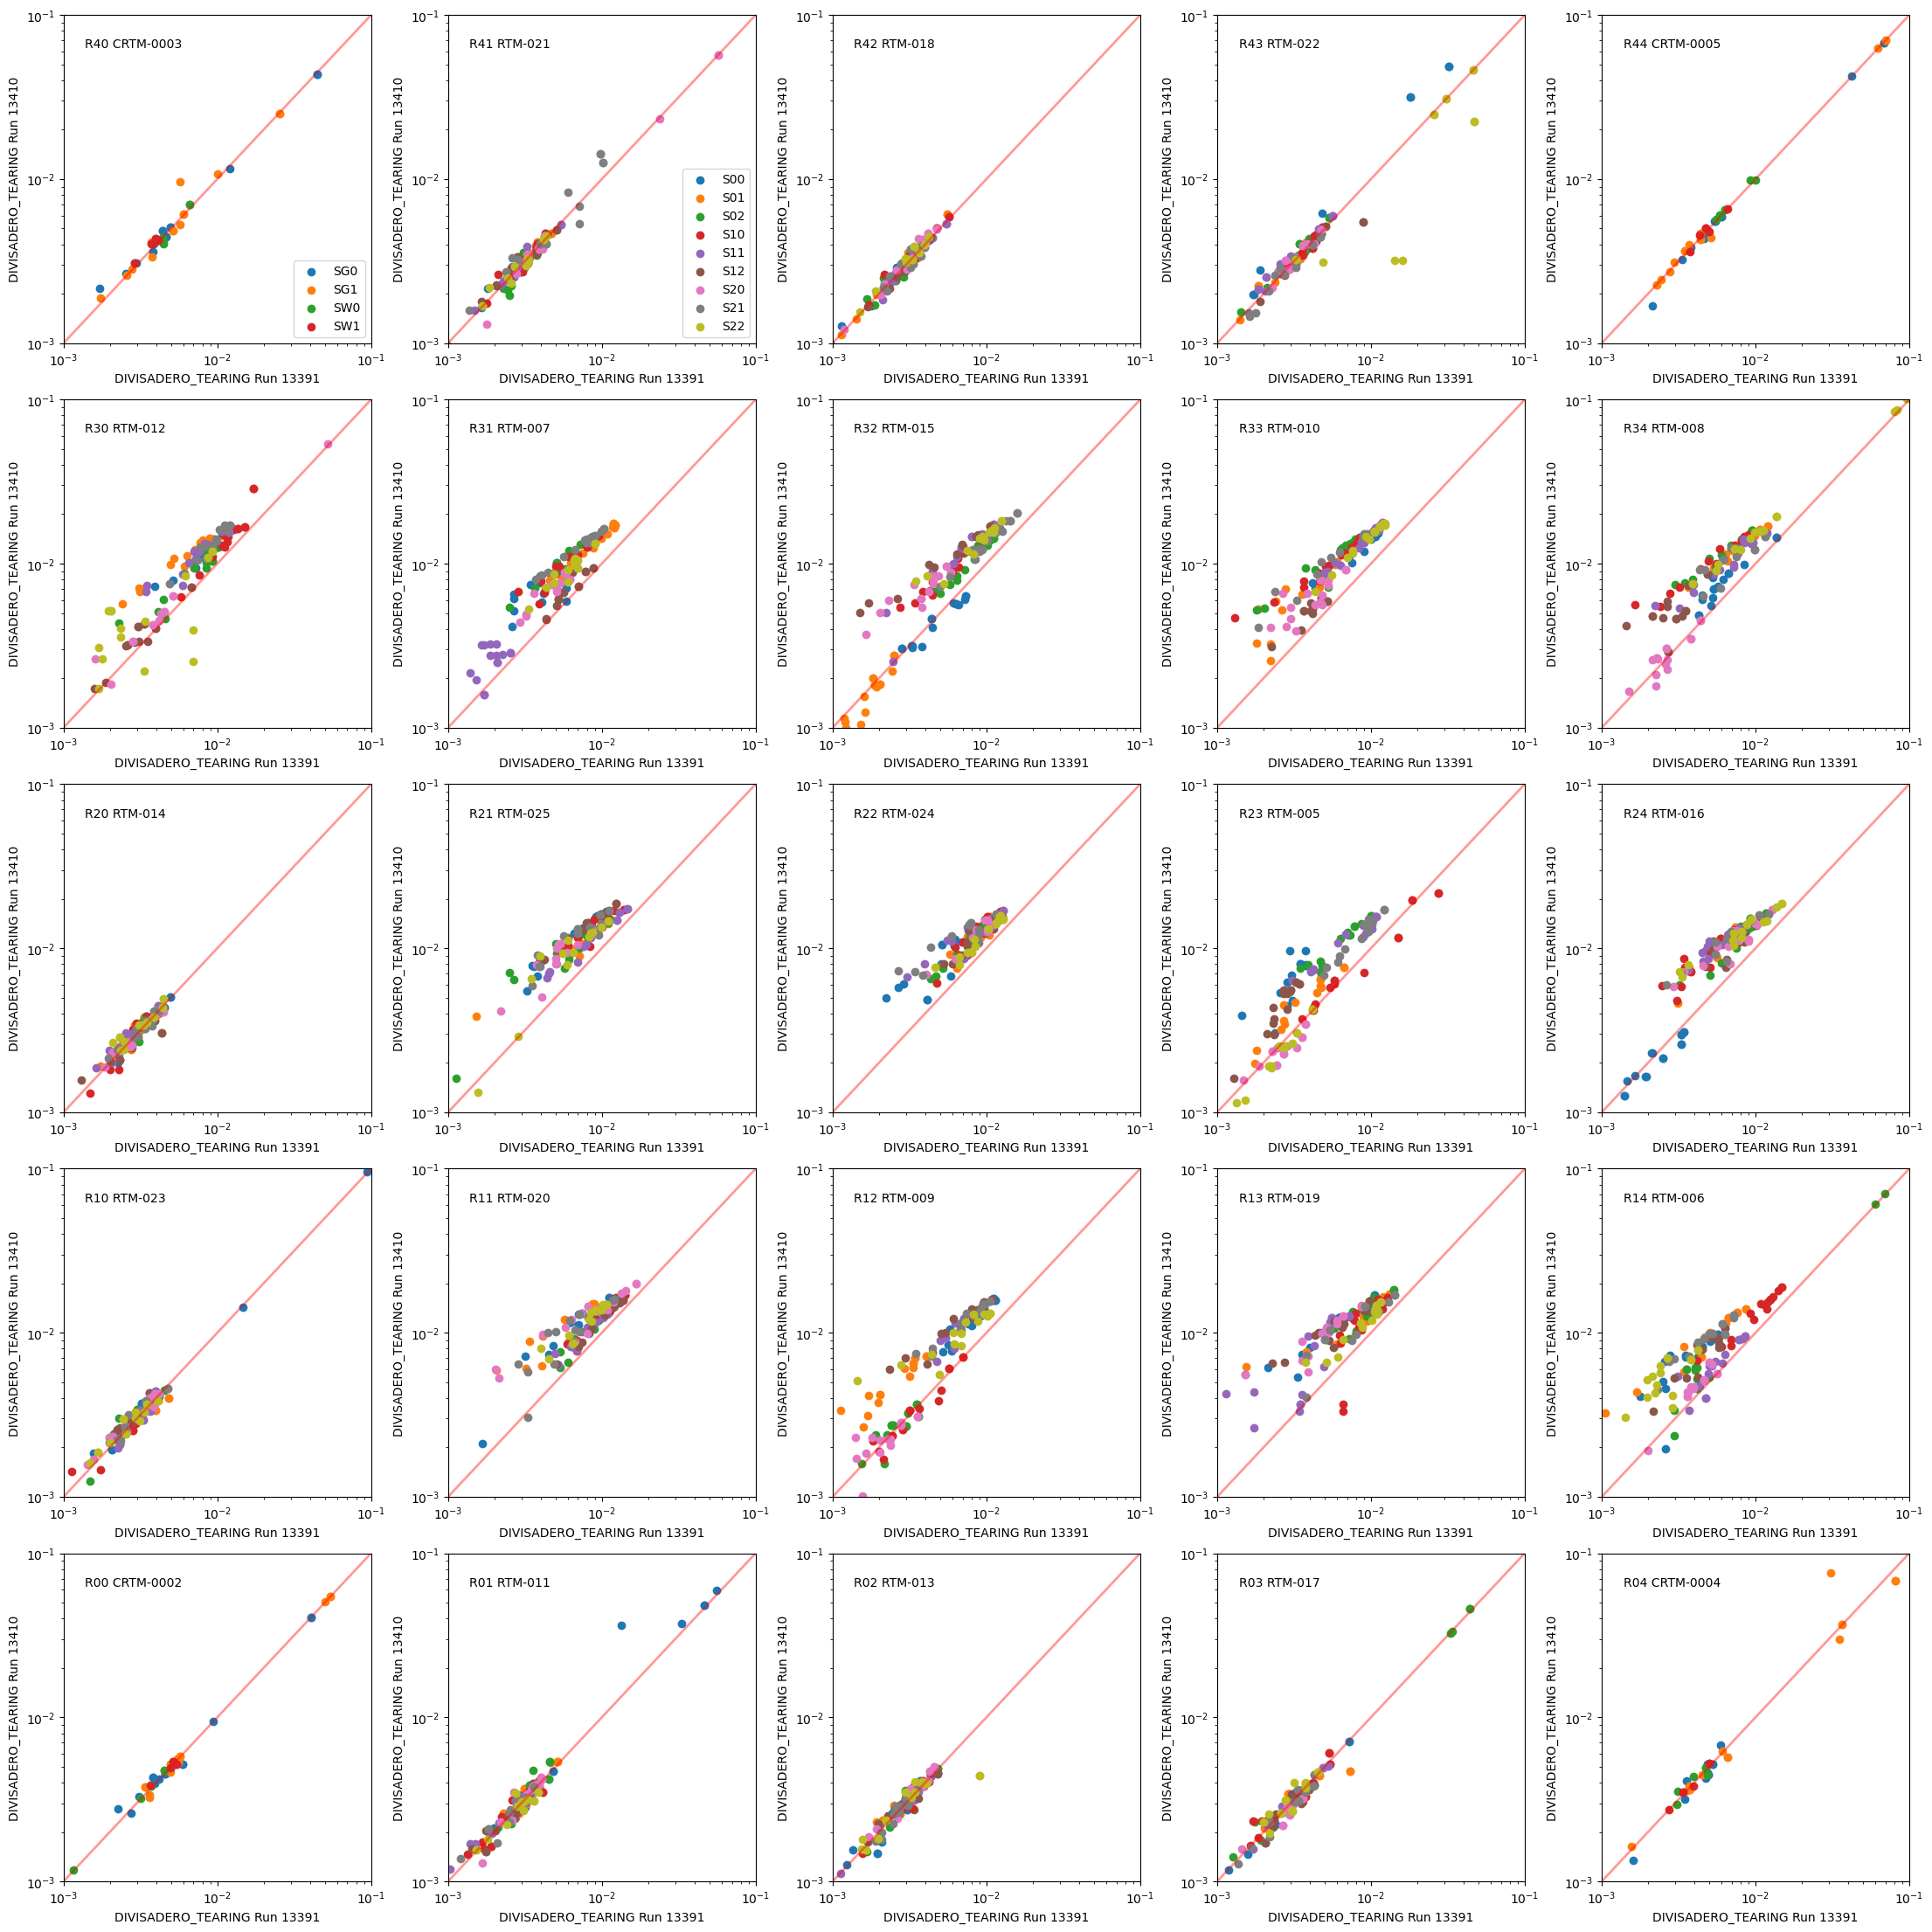

In [39]:
compare_tworuns(df_data_run1,df_data_run2,acq_run1,acq_run2,quantity='DIVISADERO_TEARING',minxy=1.0e-3,maxxy=1.0e-1,scale='log',save='divisadero_tearing_%s_vs_%s'%(acq_run1,acq_run2))

# Dark Current

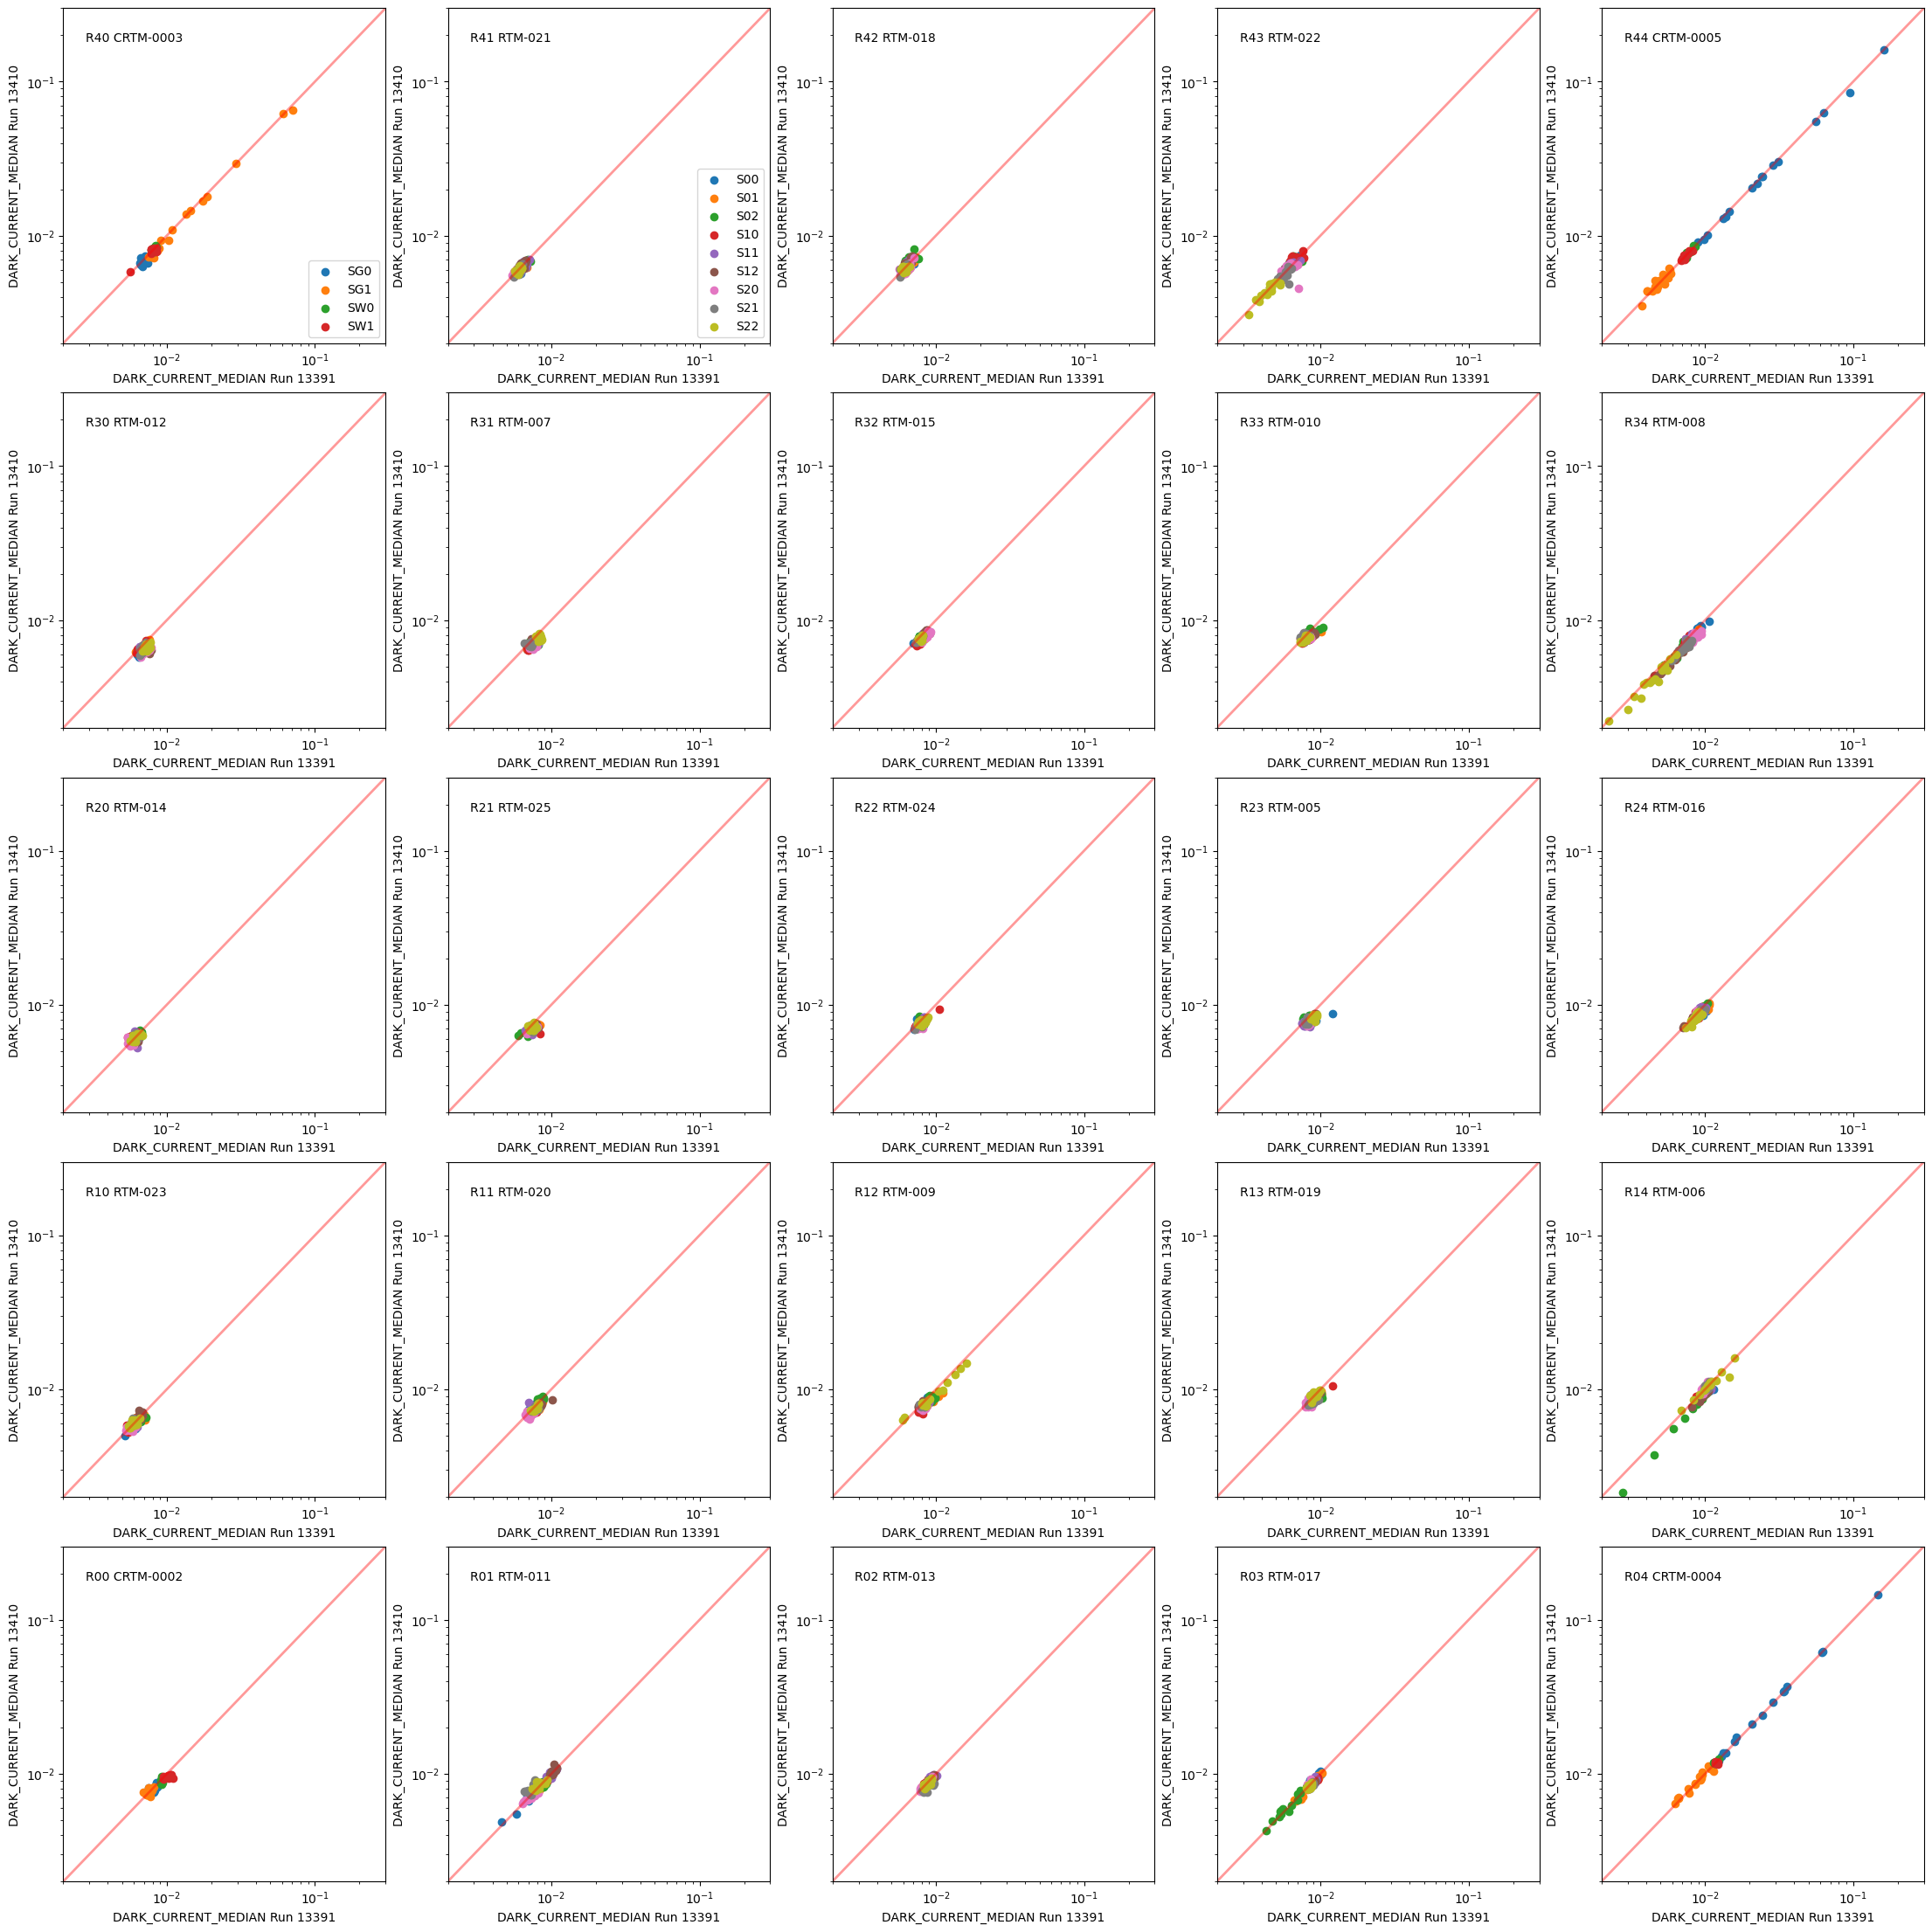

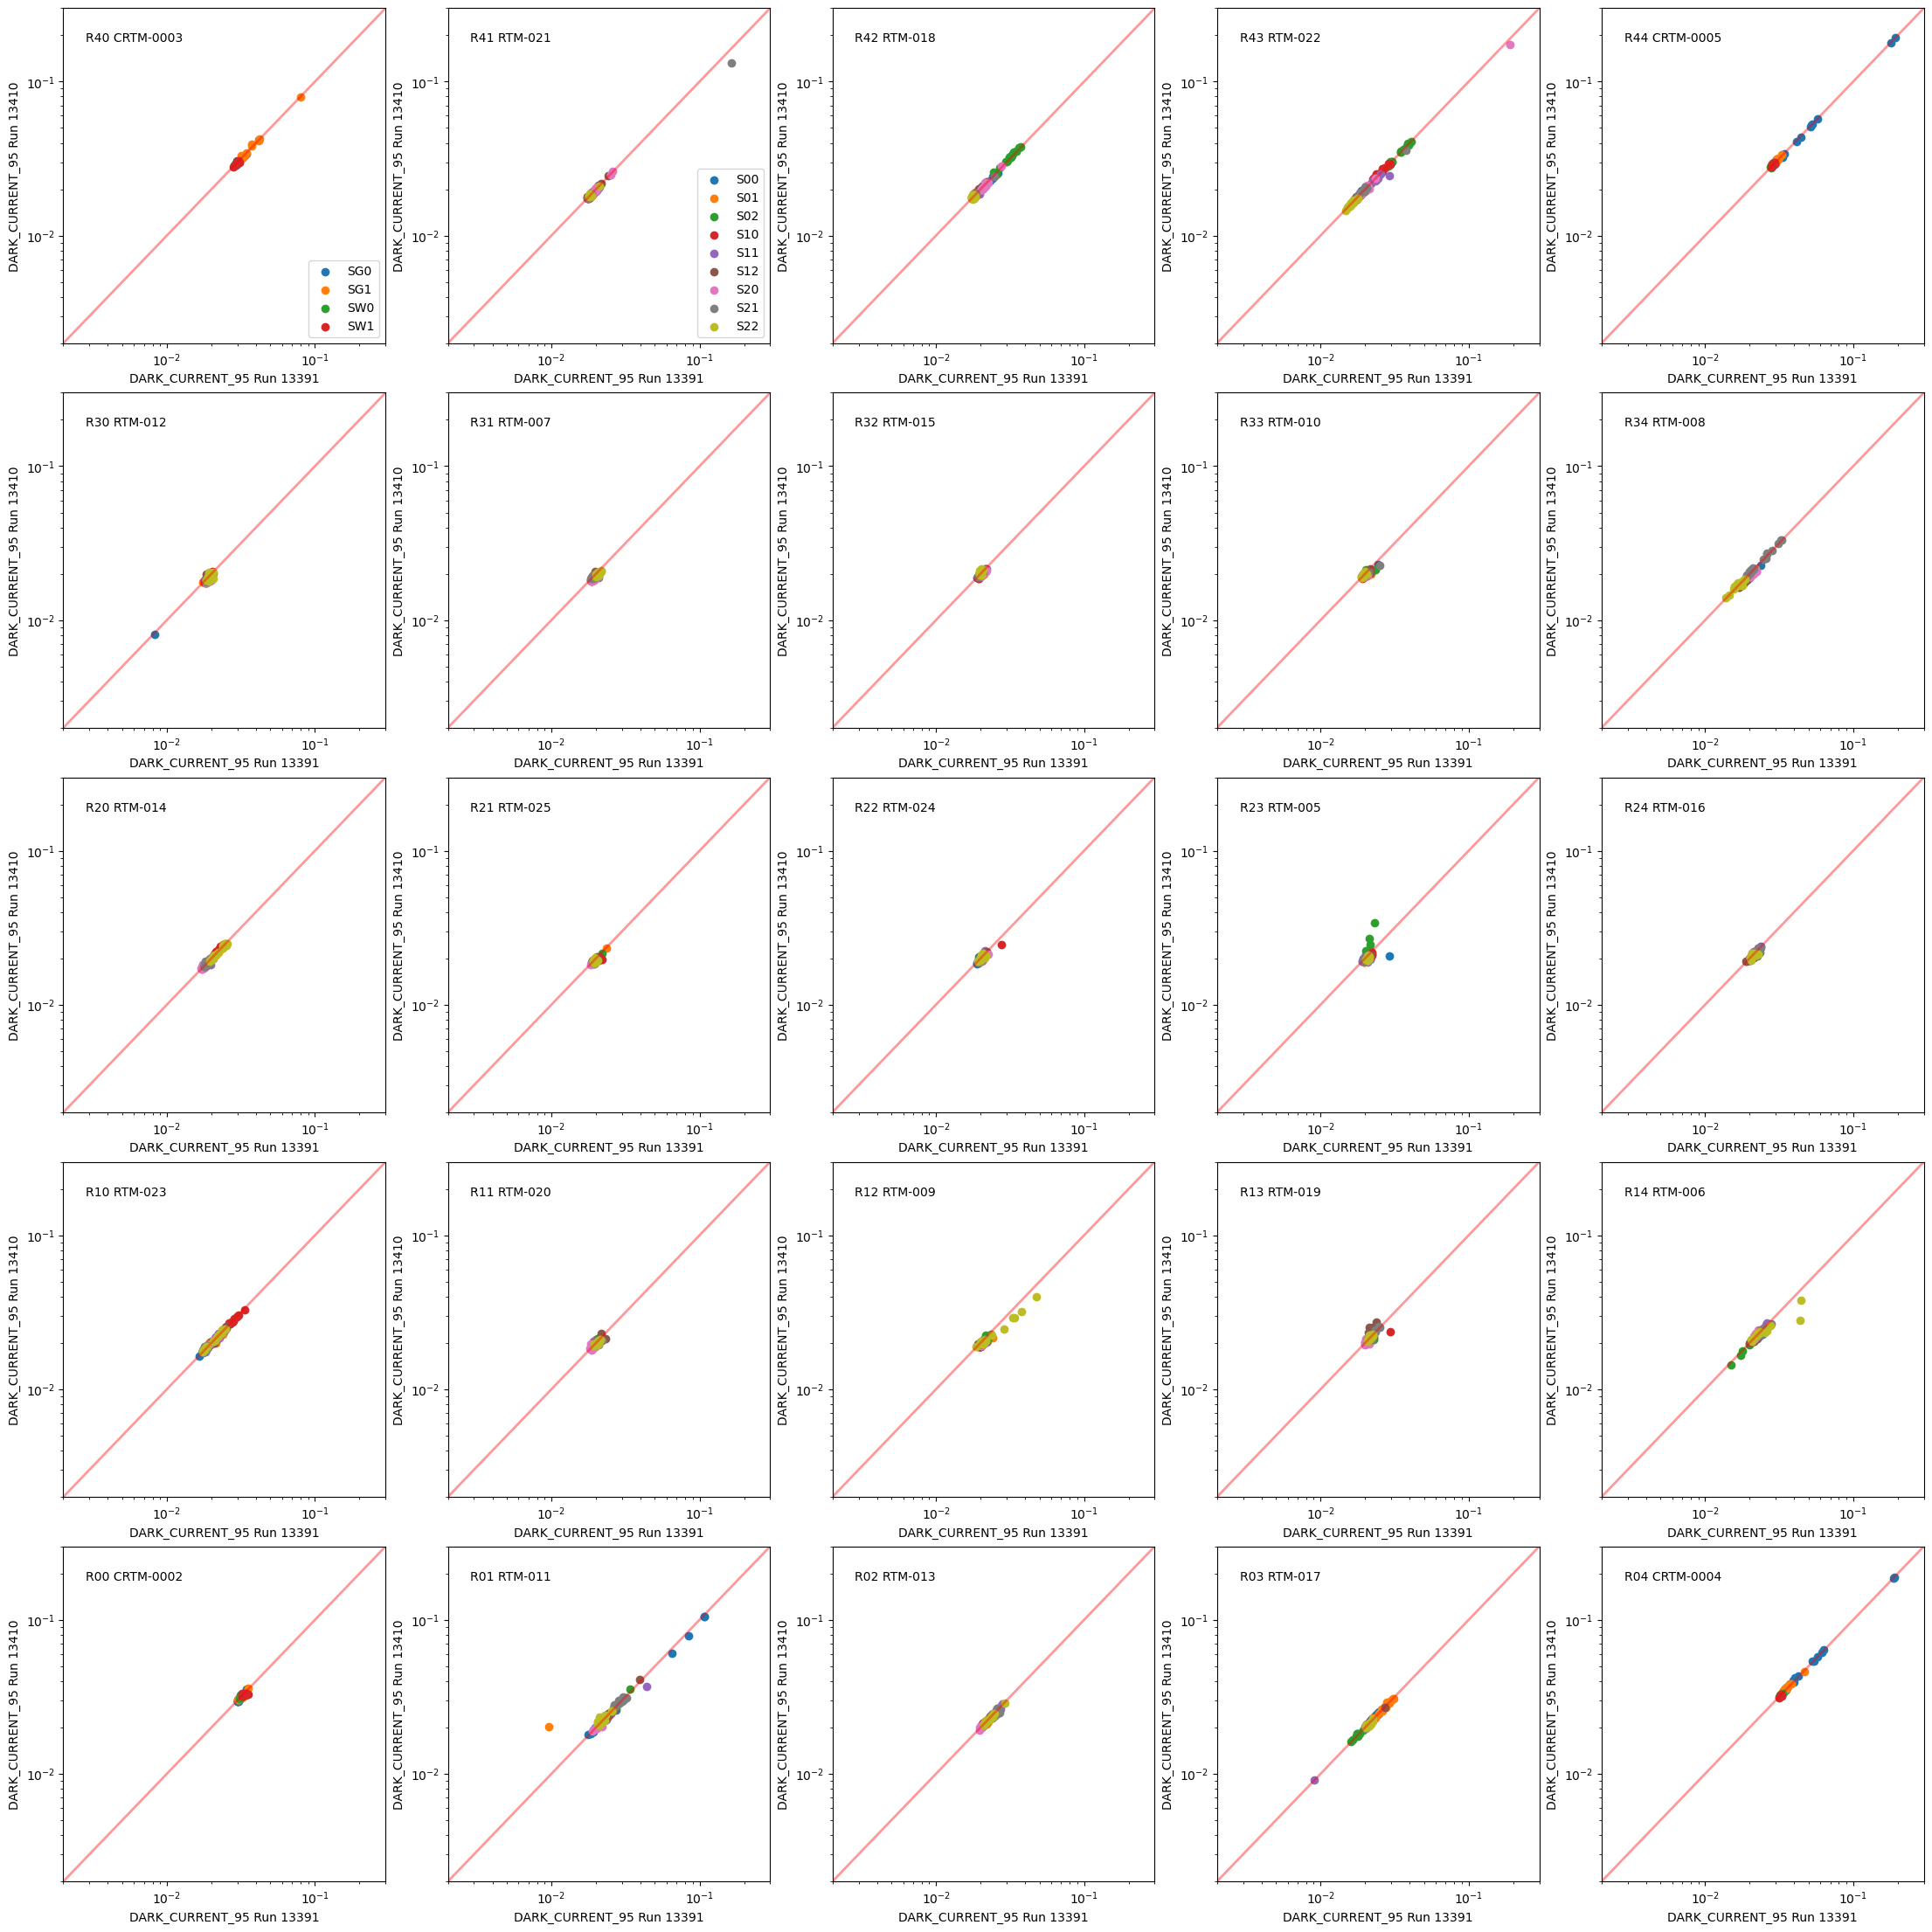

In [41]:
compare_tworuns(df_data_run1,df_data_run2,acq_run1,acq_run2,quantity='DARK_CURRENT_MEDIAN',minxy=2.0e-3,maxxy=3.0e-1,scale='log',save='darkcurrent_median_%s_vs_%s'%(acq_run1,acq_run2))
compare_tworuns(df_data_run1,df_data_run2,acq_run1,acq_run2,quantity='DARK_CURRENT_95',minxy=2.0e-3,maxxy=3.0e-1,scale='log',save='darkcurrent_95_%s_vs_%s'%(acq_run1,acq_run2))


## High Dark Current channels

In [42]:
highdarkcurrent = (df_merge.DARK_CURRENT_MEDIAN_RUN1>0.1) | (df_merge.DARK_CURRENT_MEDIAN_RUN2>0.1)
print(tabulate(df_merge[highdarkcurrent][['BAY_SLOT','SEGMENT','DARK_CURRENT_MEDIAN_RUN1','DARK_CURRENT_95_RUN1','DARK_CURRENT_MEDIAN_RUN2','DARK_CURRENT_95_RUN2','COMMENT']],headers='keys',tablefmt='psql'))

+------+------------+-----------+----------------------------+------------------------+----------------------------+------------------------+-----------+
|      | BAY_SLOT   | SEGMENT   |   DARK_CURRENT_MEDIAN_RUN1 |   DARK_CURRENT_95_RUN1 |   DARK_CURRENT_MEDIAN_RUN2 |   DARK_CURRENT_95_RUN2 | COMMENT   |
|------+------------+-----------+----------------------------+------------------------+----------------------------+------------------------+-----------|
|  482 | R04_SG0    | C12       |                   0.145895 |                1.7693  |                   0.14652  |                1.76924 | Ok        |
| 3180 | R44_SG0    | C03       |                   0.160347 |                1.77837 |                   0.161499 |                1.81429 | Ok        |
+------+------------+-----------+----------------------------+------------------------+----------------------------+------------------------+-----------+


## Dark Current Mosiac

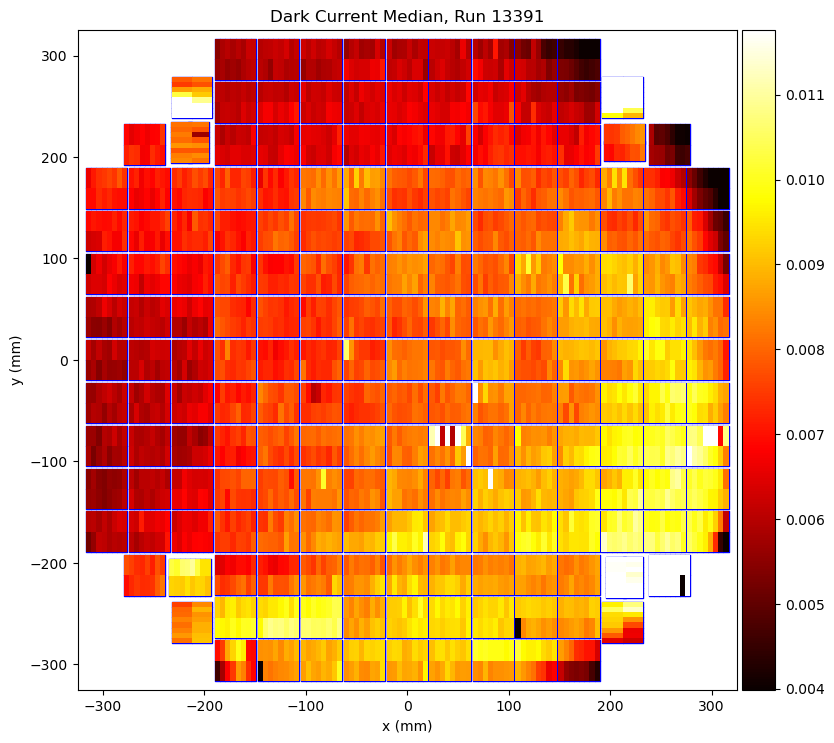

In [44]:
# These dicts of amplifier data in a format that can be used with the focal plane plotting functions in eo_pipe:
f,ax = plt.subplots(1,1,figsize=(9, 9))
h = eo_pipe.plotting.plot_focal_plane(ax, amp_data_run1['dark_current_median'], use_log10=False, nsigma=3, z_range='clipped_autoscale')
ax.set_title('Dark Current Median, Run %s'%(acq_run1))
f.savefig('darkcurrent_median_mosaic_%s'%(acq_run1))

## This pattern represents a known light leak in the Integration Stand dark box, even with the lights off in the Clean Room. 